# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess, workers = 30)

Loading ychr


In [2]:
branch_lengths1 <- future_map_dfr(1:10, function(mindp) {
    gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = mindp, maxdp = 0.98) %>% select(-ustishim)

    samples <- read_info(gt)

    crossing(
        a = filter(samples, pop == "Africa")$name,
        b = filter(samples, pop != "Africa", pop != "EMH")$name
    ) %>%
    pmap_dfr(function(a, b) {
        x <- gt[, c("chimp", a, b)] %>% filter(complete.cases(.))

        tibble(
            afr = a,
            nonafr = b,
            nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
            afr_der = sum(x[["chimp"]] != x[[a]] & x[["chimp"]] == x[[b]]),
            ratio = afr_der / nonafr_der,
            total = nrow(x),
            mindp = mindp
        )    
    })
})

In [3]:
branch_lengths2 <- future_map_dfr(1:10, function(mindp) {
    x <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = mindp, maxdp = 0.98) %>%
        select(-ustishim) %>%
        filter(complete.cases(.))

    samples <- read_info(x)

    crossing(
        a = filter(samples, pop == "Africa")$name,
        b = filter(samples, pop != "Africa", pop != "EMH")$name
    ) %>%
    pmap_dfr(function(a, b) {
        tibble(
            afr = a,
            nonafr = b,
            nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
            afr_der = sum(x[["chimp"]] != x[[a]] & x[["chimp"]] == x[[b]]),
            ratio = afr_der / nonafr_der,
            total = nrow(x),
            mindp = mindp
        )    
    })
})

In [4]:
branch_lengths3 <- future_map_dfr(1:10, function(mindp) {
    map_dfr(c("den4", "den8", "spy1", "mez2"), function(arch) {
        gt <- read_genotypes(arch, "full", mindp = mindp, maxdp = 0.98) %>%
            select(-ustishim)

        samples <- read_info(gt)

        crossing(
            a = filter(samples, pop == "Africa")$name,
            b = filter(samples, pop != "Africa", pop != "EMH")$name
        ) %>%
        pmap_dfr(function(a, b) {
            x <- gt[, c("chimp", a, b, arch)] %>% filter(complete.cases(.))

            tibble(
                arch = arch,
                afr = a,
                nonafr = b,
                nonafr_der = sum(x[["chimp"]] == x[[a]] & x[["chimp"]] != x[[b]]),
                afr_der = sum(x[["chimp"]] != x[[a]] & x[["chimp"]] == x[[b]]),
                ratio = afr_der / nonafr_der,
                total = nrow(x),
                mindp = mindp
            )    
        })
    })
})

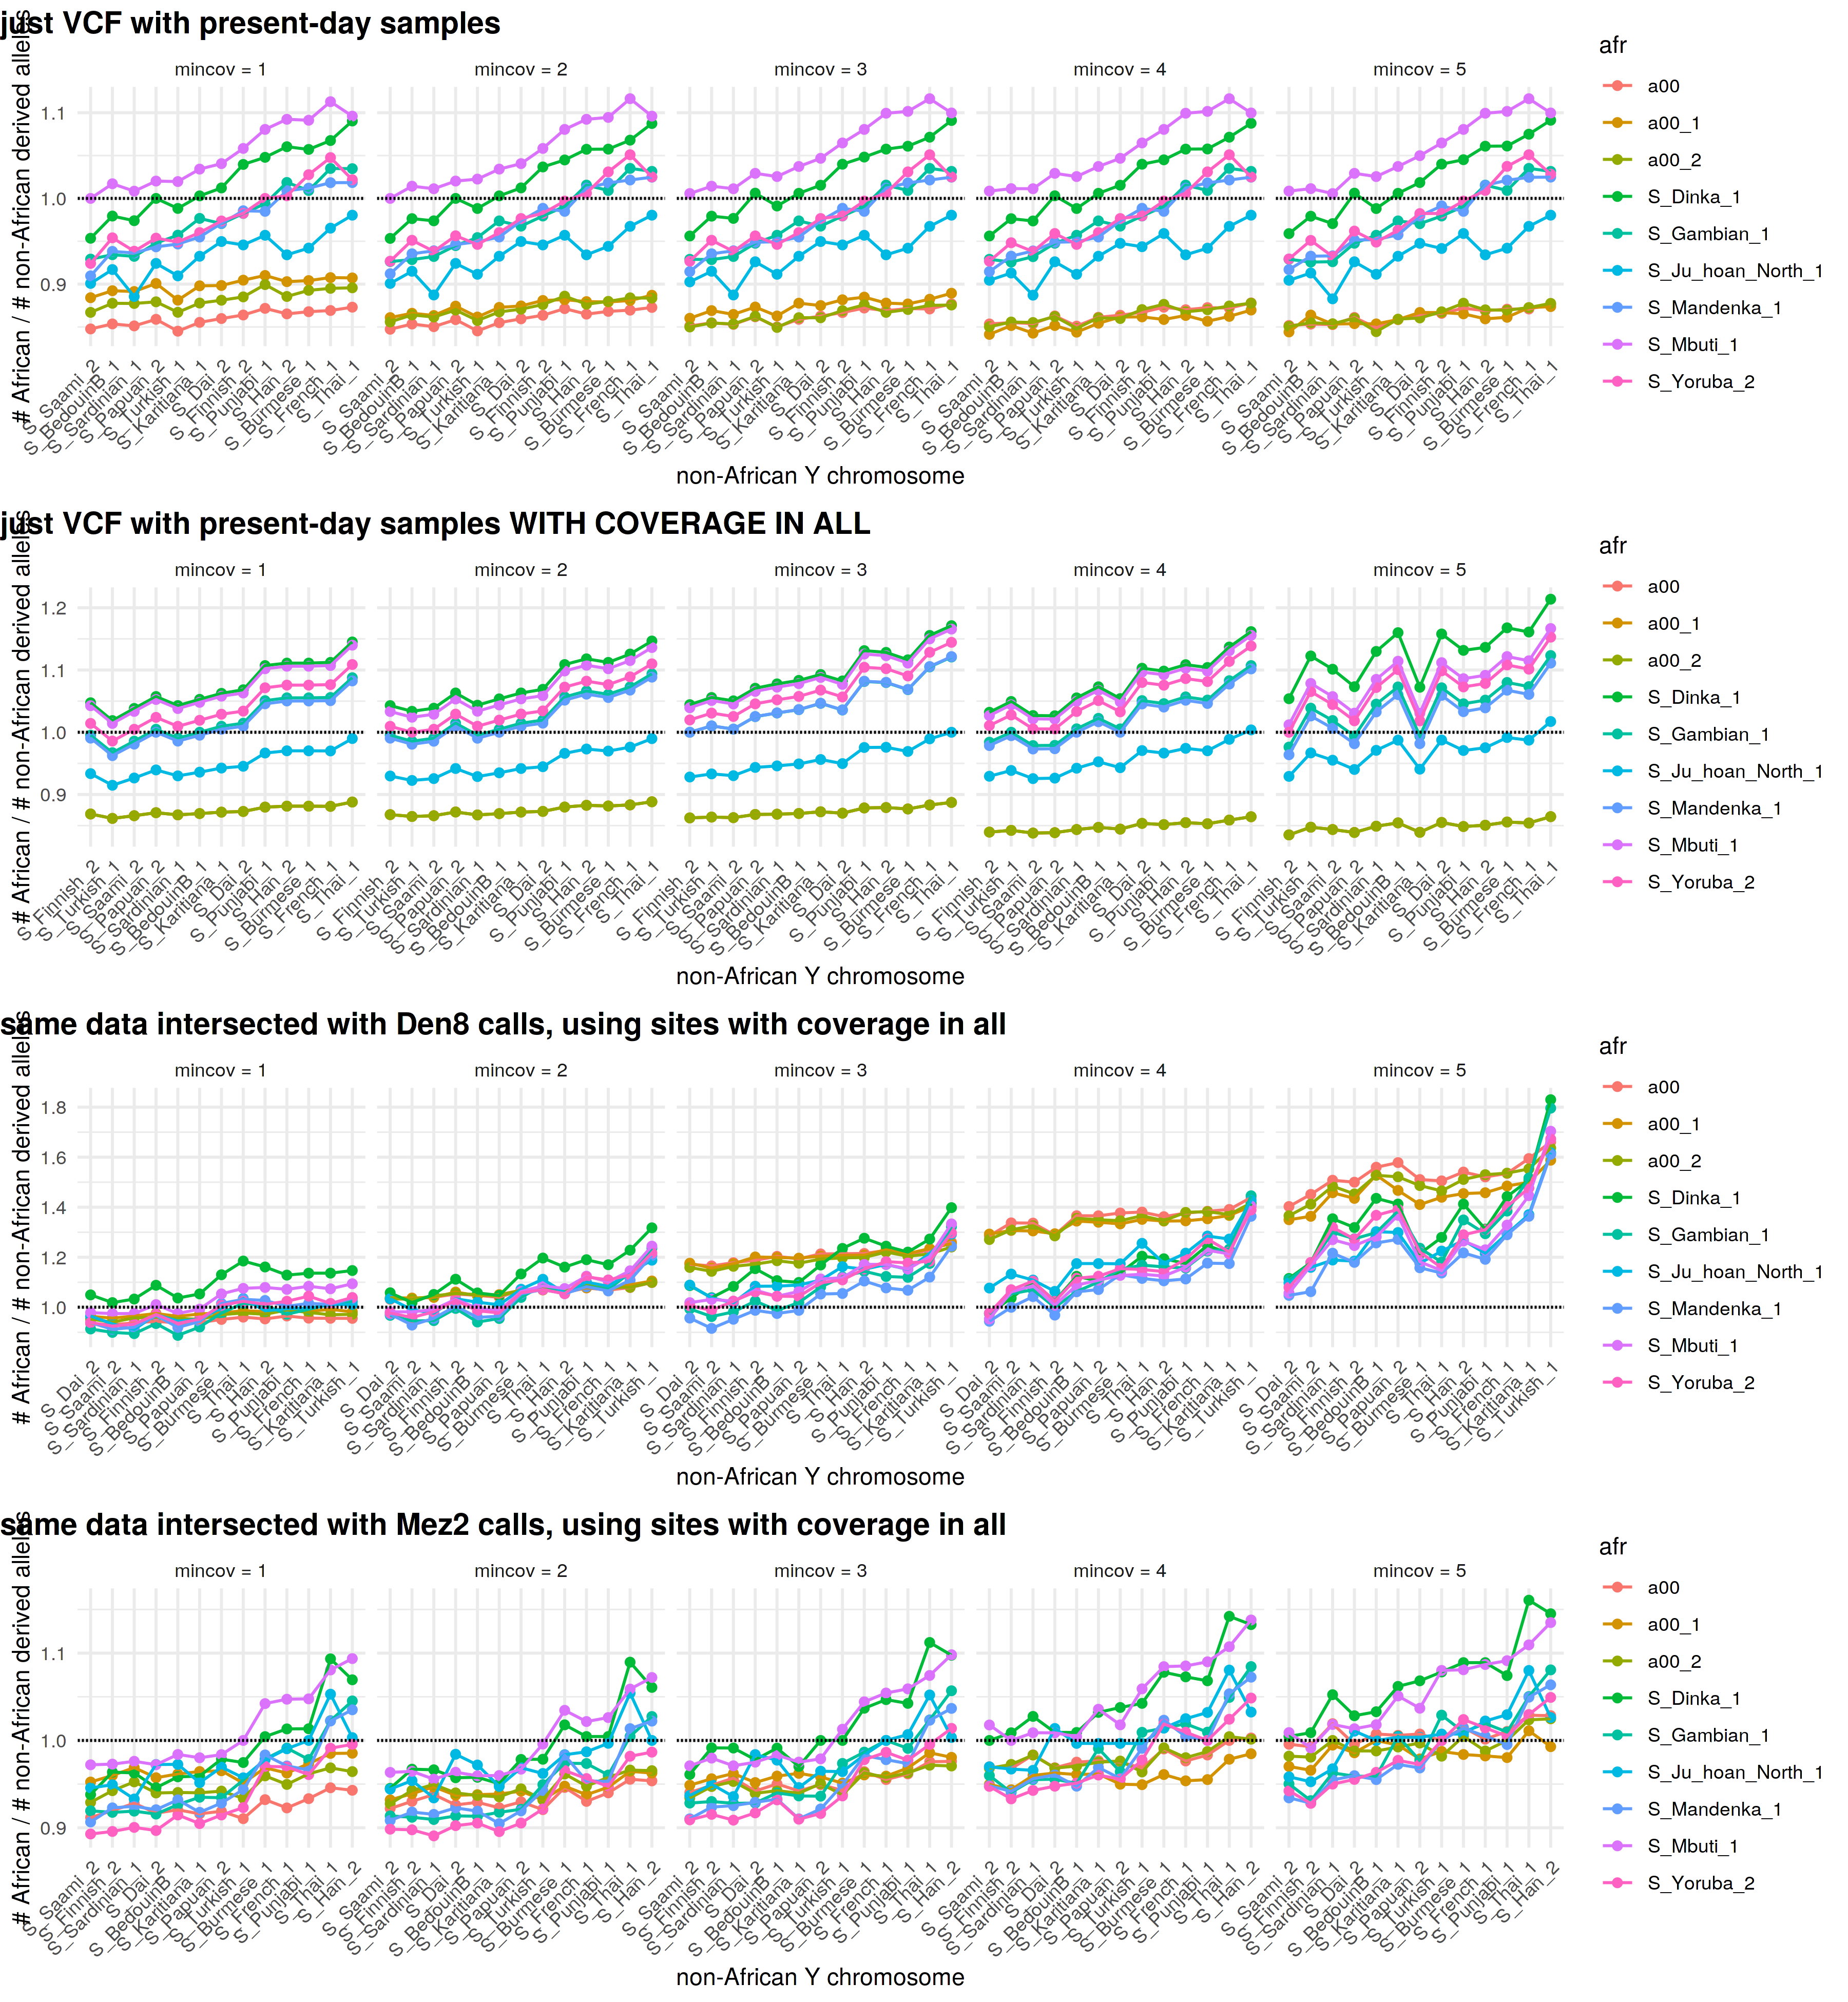

In [7]:
p1 <- branch_lengths1 %>%
filter(mindp <= 5) %>% mutate(mindp = paste0("mincov = ", mindp)) %>% 
ggplot(aes(fct_reorder(nonafr, ratio), ratio, color = afr, group = afr)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ mindp, nrow = 1) +
    labs(x = "non-African Y chromosome", y = "# African / # non-African derived alleles") +
    theme_minimal() + ggtitle("") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

p2 <- branch_lengths2 %>%
filter(mindp <= 5) %>% mutate(mindp = paste0("mincov = ", mindp)) %>% 
ggplot(aes(fct_reorder(nonafr, ratio), ratio, color = afr, group = afr)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ mindp, nrow = 1) +
    labs(x = "non-African Y chromosome", y = "# African / # non-African derived alleles") +
    theme_minimal() + ggtitle("") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

p3 <- branch_lengths3 %>% filter(arch == "den8") %>%
filter(mindp <= 5) %>% mutate(mindp = paste0("mincov = ", mindp)) %>% 
ggplot(aes(fct_reorder(nonafr, ratio), ratio, color = afr, group = afr)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ mindp, nrow = 1) +
    labs(x = "non-African Y chromosome", y = "# African / # non-African derived alleles") +
    theme_minimal() + ggtitle("") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

p4 <- branch_lengths3 %>% filter(arch == "mez2") %>%
filter(mindp <= 5) %>% mutate(mindp = paste0("mincov = ", mindp)) %>% 
ggplot(aes(fct_reorder(nonafr, ratio), ratio, color = afr, group = afr)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept = 1, linetype = 2) +
    facet_wrap(~ mindp, nrow = 1) +
    labs(x = "non-African Y chromosome", y = "# African / # non-African derived alleles") +
    theme_minimal() + ggtitle("") +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))

set_dim(12, 13)

plot_grid(p1, p2, p3, p4, nrow = 4,
          labels = c("just VCF with present-day samples",
                     "just VCF with present-day samples WITH COVERAGE IN ALL",
                     "same data intersected with Den8 calls, using sites with coverage in all",
                     "same data intersected with Mez2 calls, using sites with coverage in all"),
          hjust = "left")

In [8]:
afr_dp <- future_map_dfr(1:10, function(mindp) {
    highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = mindp, maxdp = 0.98)
    run_step1(highcov_gt) %>%
        mutate(mindp = mindp,
               tmrca_afr2 = (a + d) / (total * mut_rate))
})

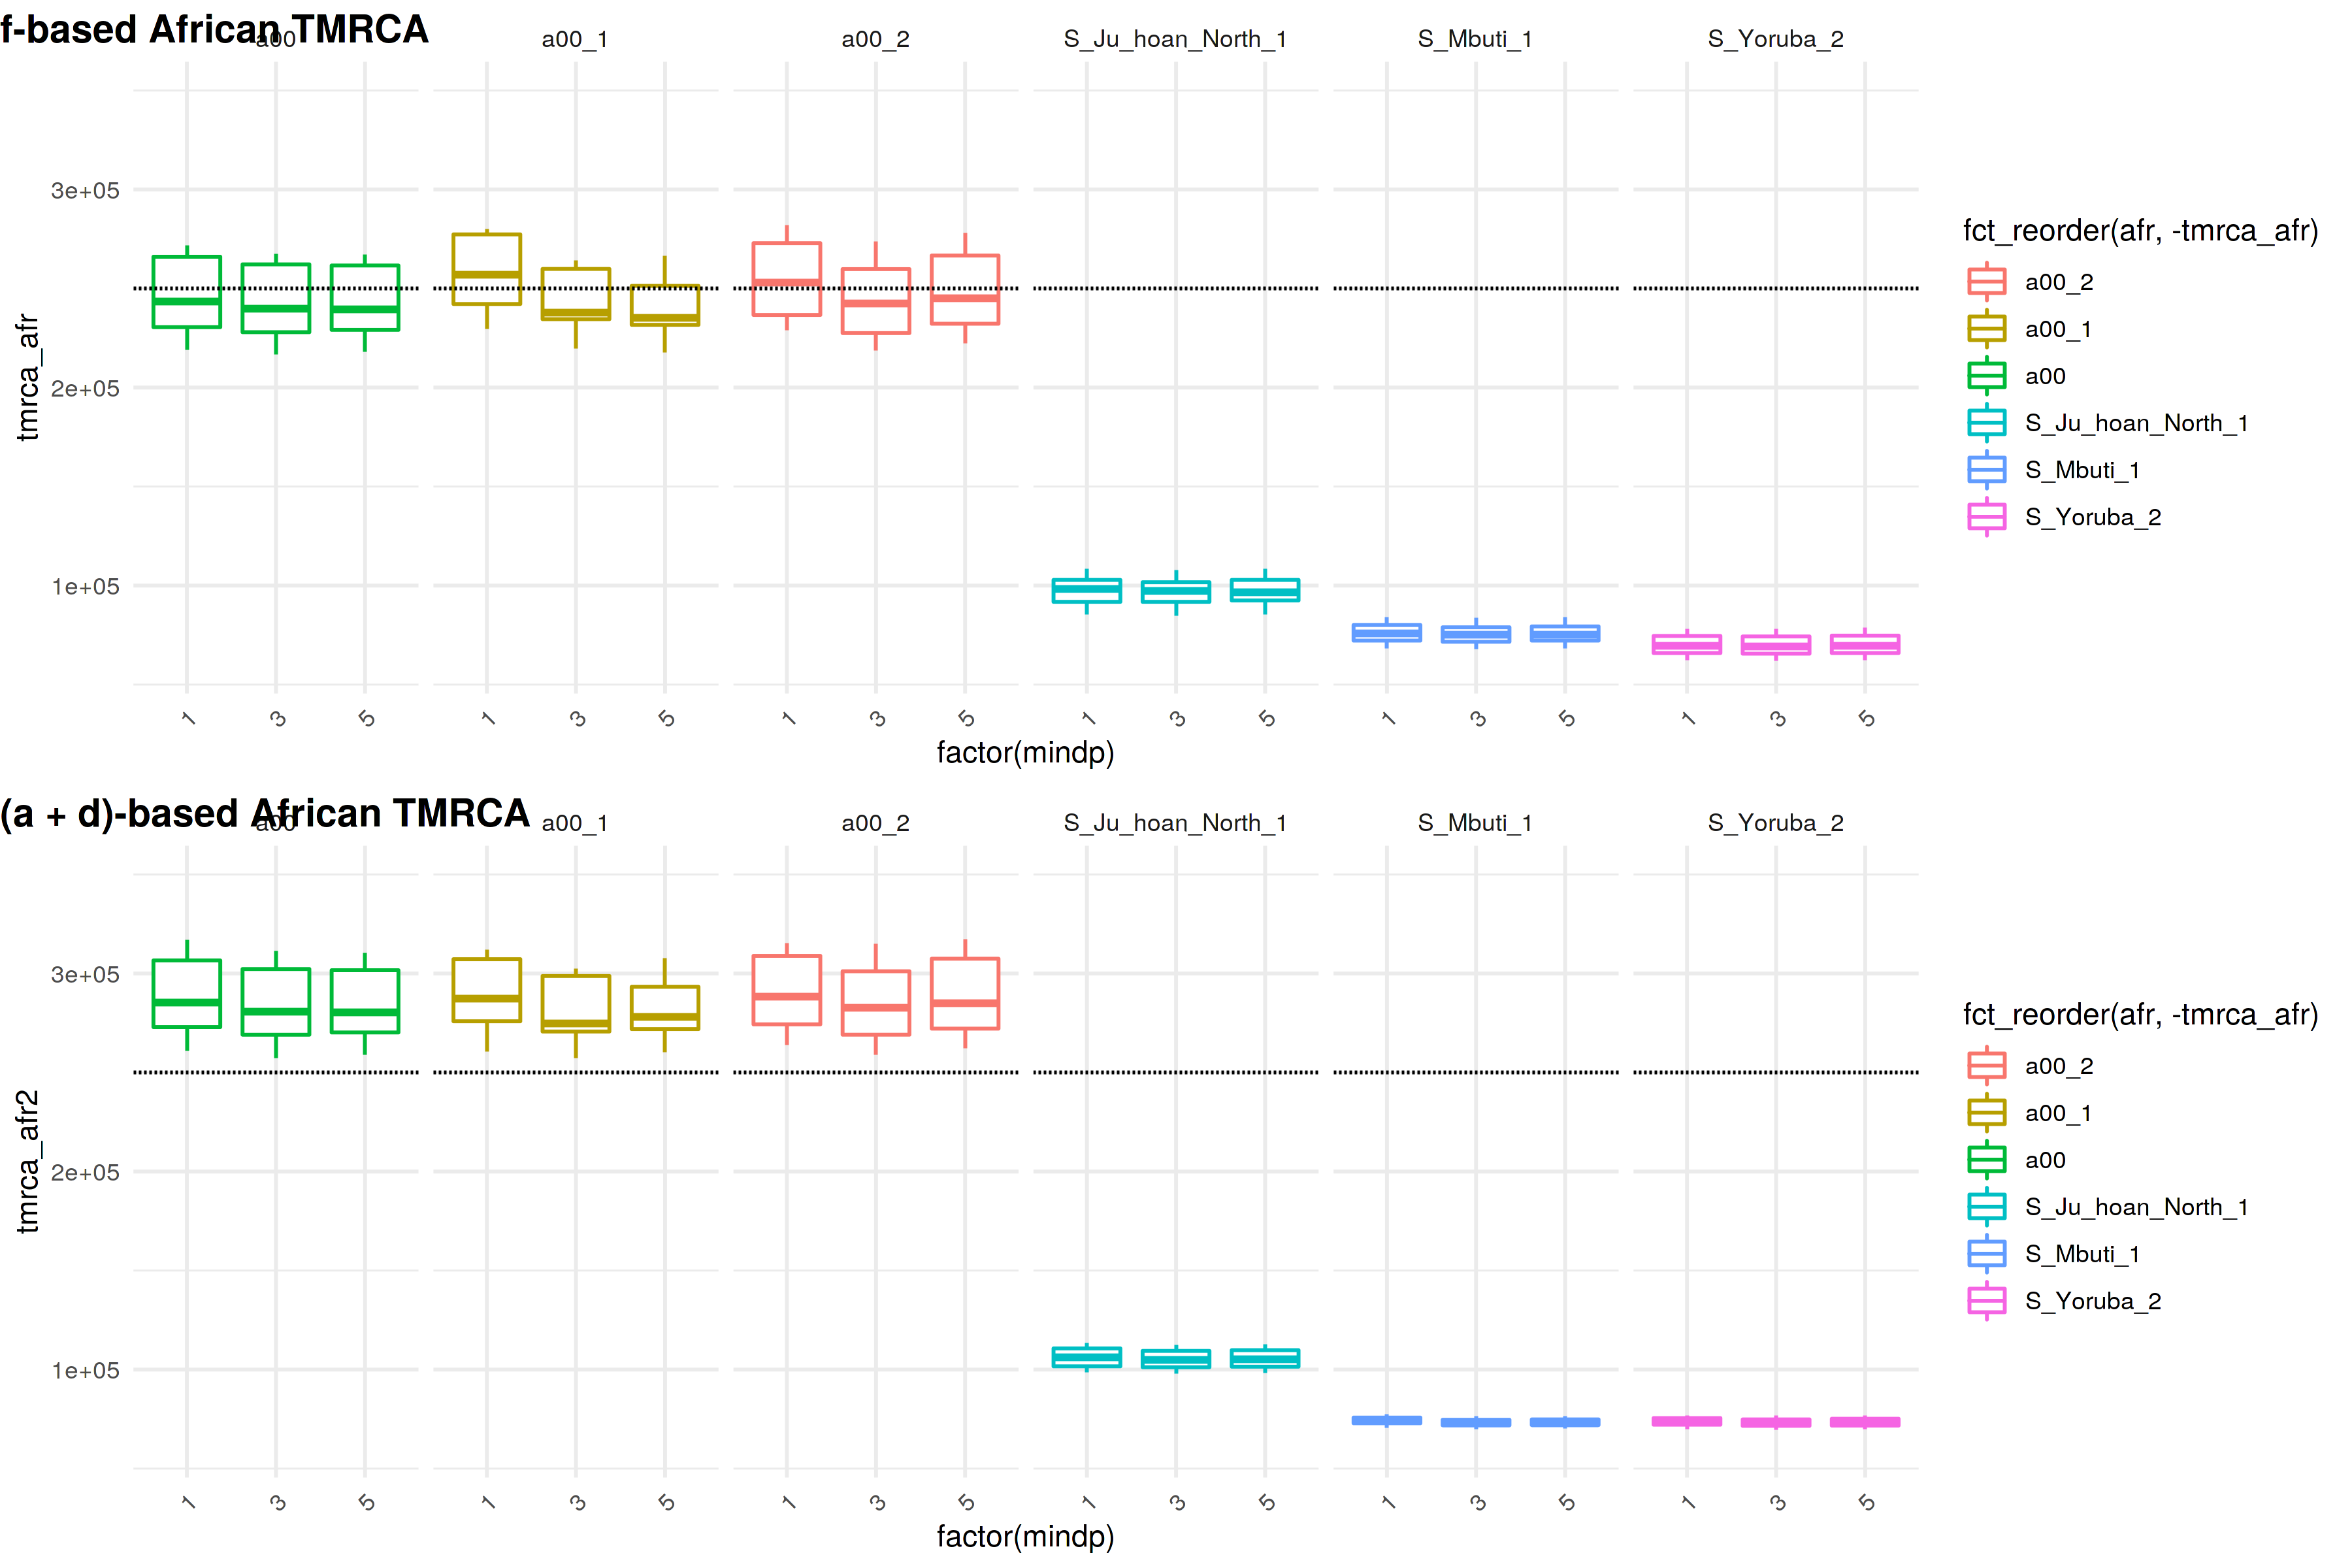

In [9]:
p1 <- afr_dp %>%
filter(mindp %in% c(1, 3, 5), !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
ggplot(aes(factor(mindp), tmrca_afr, color = fct_reorder(afr, -tmrca_afr))) +
    geom_boxplot() +
    theme_minimal() +
    theme(legend.position = "right", axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_grid(. ~ afr) +
    ylim(60000, 350000) +
    geom_hline(yintercept = 250000, linetype = 2)

p2 <- afr_dp %>%
filter(mindp %in% c(1, 3, 5), !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
ggplot(aes(factor(mindp), tmrca_afr2, color = fct_reorder(afr, -tmrca_afr))) +
    geom_boxplot() +
    theme_minimal() +
    theme(legend.position = "right", axis.text.x = element_text(hjust = 1, angle = 45)) +
    facet_grid(. ~ afr) +
    ylim(60000, 350000) +
    geom_hline(yintercept = 250000, linetype = 2)

set_dim(12, 8)

plot_grid(p1, p2, nrow = 2, labels = c("f-based African TMRCA", "(a + d)-based African TMRCA"), hjust = "left")

In [10]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.98)

In [11]:
step1 <- run_step1(highcov_gt)

In [12]:
step1 %>% group_by(afr) %>% summarise_if(is.numeric, mean)

afr               a         b        c        d        e        f        
1 a00               976.00000 1.153846 7.615385 198.4615 11.84615 1002.8462
2 a00_1             936.76923 1.153846 7.461538 194.4615 11.84615  980.1538
3 a00_2             973.46154 1.153846 7.153846 197.6154 12.23077 1002.8462
4 S_Dinka_1          97.92308 2.000000 8.384615 203.0769 12.15385  297.3077
5 S_Gambian_1       101.61538 1.153846 8.230769 204.4615 12.15385  291.0769
6 S_Ju_hoan_North_1 240.07692 2.615385 8.230769 202.1538 12.15385  406.8462
7 S_Mandenka_1      111.46154 1.153846 8.230769 203.3846 12.15385  298.0769
8 S_Mbuti_1         106.92308 1.153846 8.307692 203.3846 12.15385  319.3077
9 S_Yoruba_2        107.61538 1.153846 7.846154 202.0000 11.23077  294.0769
  total   mut_rate     tmrca_afr
1 5785324 7.167527e-10 243052.19
2 5640849 7.193643e-10 242439.68
3 5762448 7.148795e-10 244702.92
4 5823451 7.285147e-10  70377.02
5 5851225 7.303169e-10  68410.84
6 5850920 7.215946e-10  96836.25
7 5885064 7.220496e-10  70429.30
8 5882409 7.223796e-10  75465.44
9 5860753 7.232816e-10  69730.50

In [13]:
estimate_grid <- function(samples, regions, mindp) {
    filters <- c("filt50" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_50.bed.gz",
                 "filt100" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz")
    
    map_dfr(samples, function(arch) {
        map_dfr(c("all", "tv_only"), function(sites) {
            map_dfr(c("filt50", "filt100"), function(filt) {
                future_map_dfr(mindp, function(dp) {
                    read_genotypes(arch, regions, mindp = dp, maxdp = 0.98, tv_only = (sites == "tv_only"),
                                   bed_filter = filters[filt]) %>%
                        run_step2(step1) %>%
                        mutate(dp = dp, sites = sites, filt = filt, capture = regions)
                })
            })
        })
    })
}

In [14]:
tmrca_df <- estimate_grid(c("den4", "den8", "spy1", "mez2", paste0("mez2_dp", 1:10)), "full", 1:10)

Warning message:
“Removed 2 rows containing missing values (geom_point).”

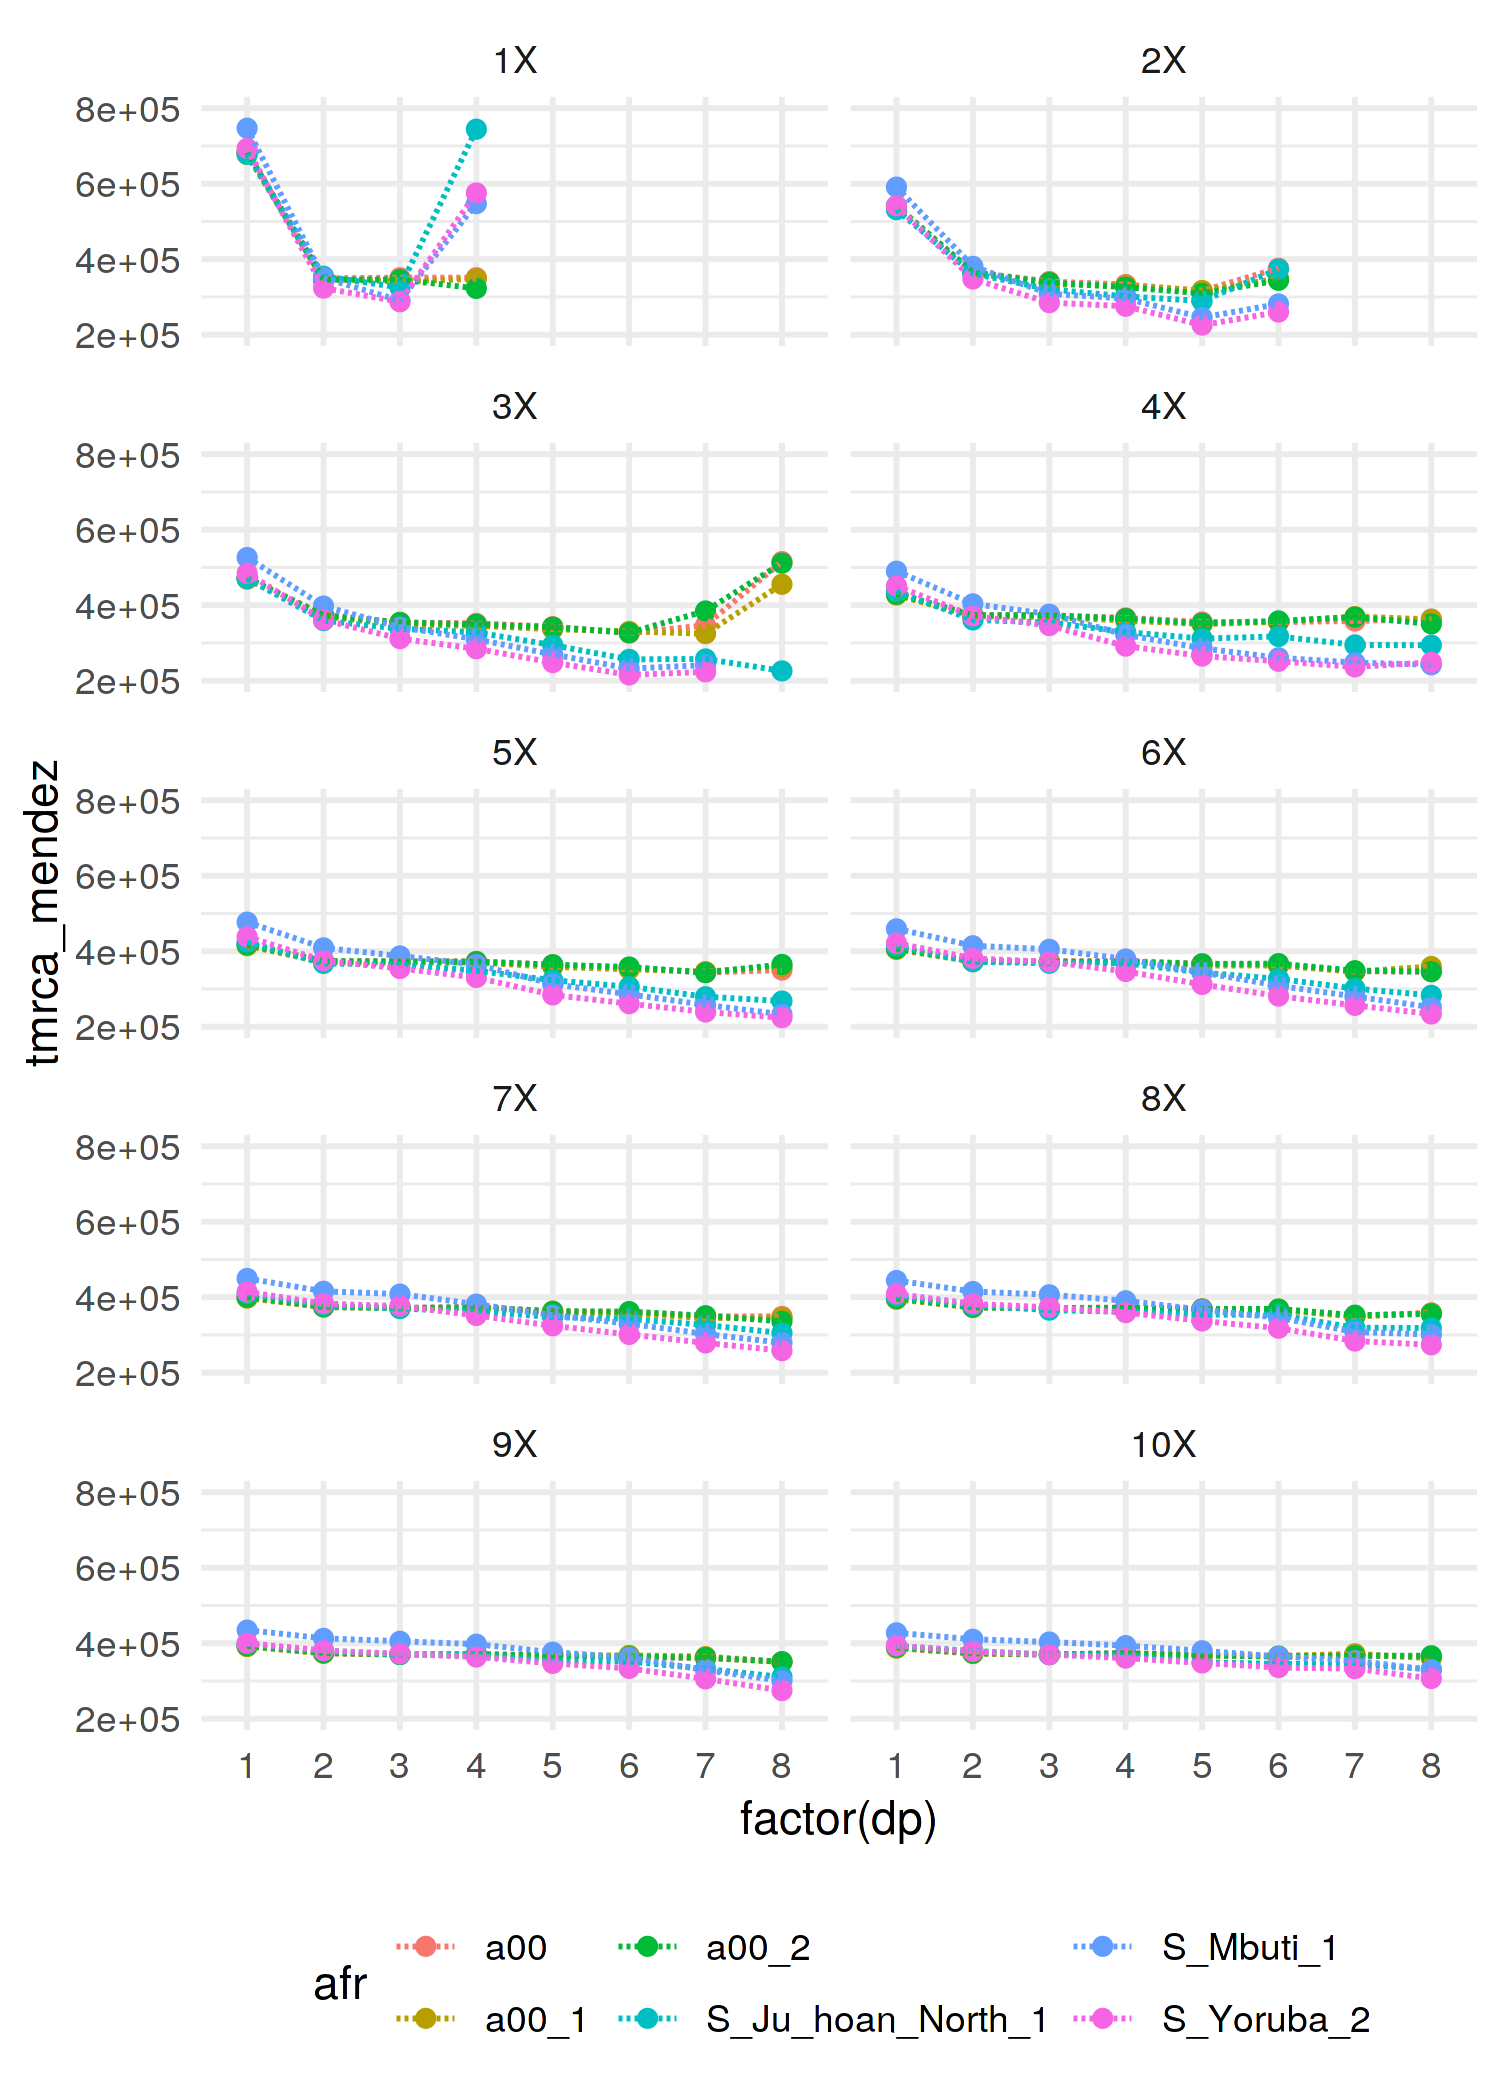

In [18]:
set_dim(5, 7)

tmrca_df %>%
filter(str_detect(arch, "mez2_dp")) %>%
mutate(arch = str_replace(arch, "mez2_dp(\\d+)", "\\1X")) %>% 
filter(dp <= 8, capture == "full", sites == "all", filt == "filt50",
      !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
mutate(arch = factor(arch, levels = paste0(1:10, "X"))) %>%
filter(!is.infinite(tmrca_new), !is.nan(tmrca_new)) %>% {
ggplot(., aes(factor(dp), tmrca_mendez, color = afr)) +
    geom_point(data = group_by(., arch, afr, dp) %>% summarise_if(is.numeric, mean), aes(factor(dp), tmrca_new)) +
    geom_line(data = group_by(., arch, afr, dp) %>% summarise_if(is.numeric, mean), aes(factor(dp), tmrca_new, group = afr), linetype = 2) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    facet_wrap(~ arch, ncol = 2) + ylim(c(200000, 800000))
}

Warning message:
“Removed 474 rows containing non-finite values (stat_boxplot).”

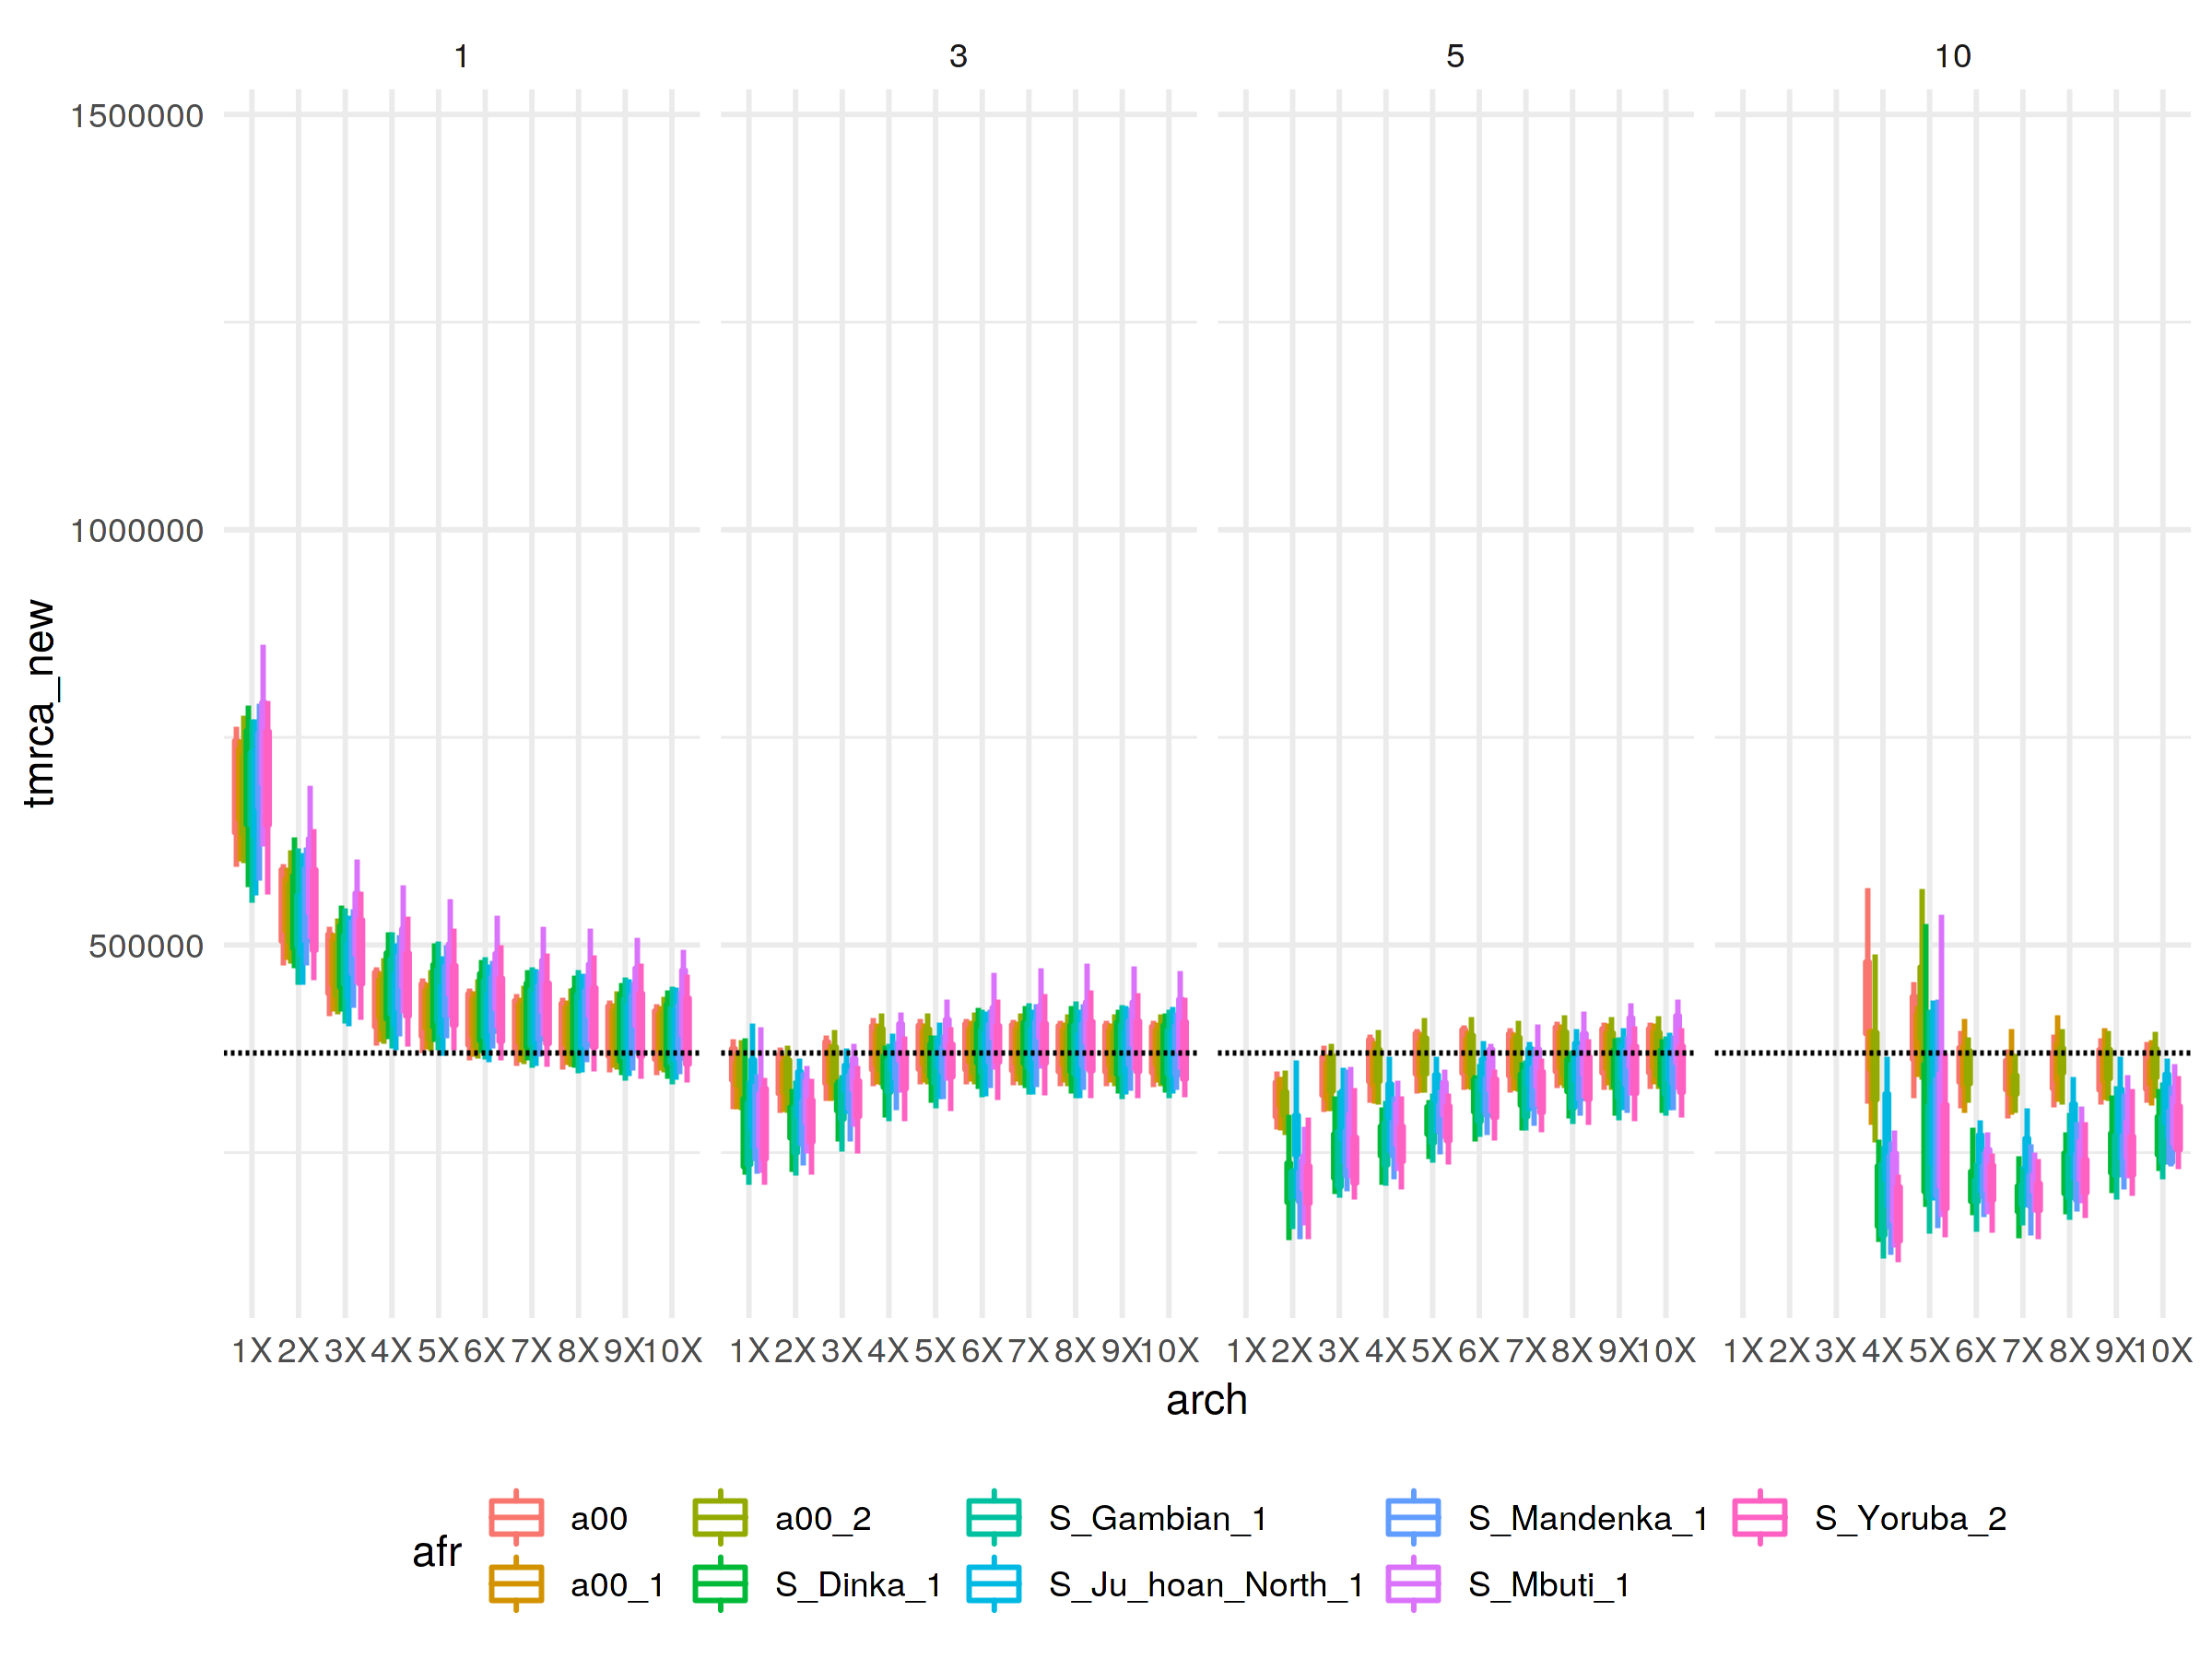

In [21]:
set_dim(8, 6)

tmrca_df %>% filter(str_detect(arch, "mez2_dp")) %>%
mutate(arch = str_replace(arch, "mez2_dp(\\d+)", "\\1X")) %>% 
filter(capture == "full", sites == "all", filt == "filt50") %>%
filter(dp %in% c(1, 3, 5, 10)) %>%
mutate(arch = factor(arch, levels = paste0(1:10, "X"))) %>% {
ggplot(., aes(arch, tmrca_new, color = afr)) +
    geom_boxplot(outlier.shape = NA, alpha = 0.1) +
#    geom_point(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new)) +
#    geom_line(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new, group = afr), linetype = 2) +
    geom_hline(yintercept = 370e3, linetype = 2) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    facet_wrap(dp ~ ., nrow = 1)
}

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

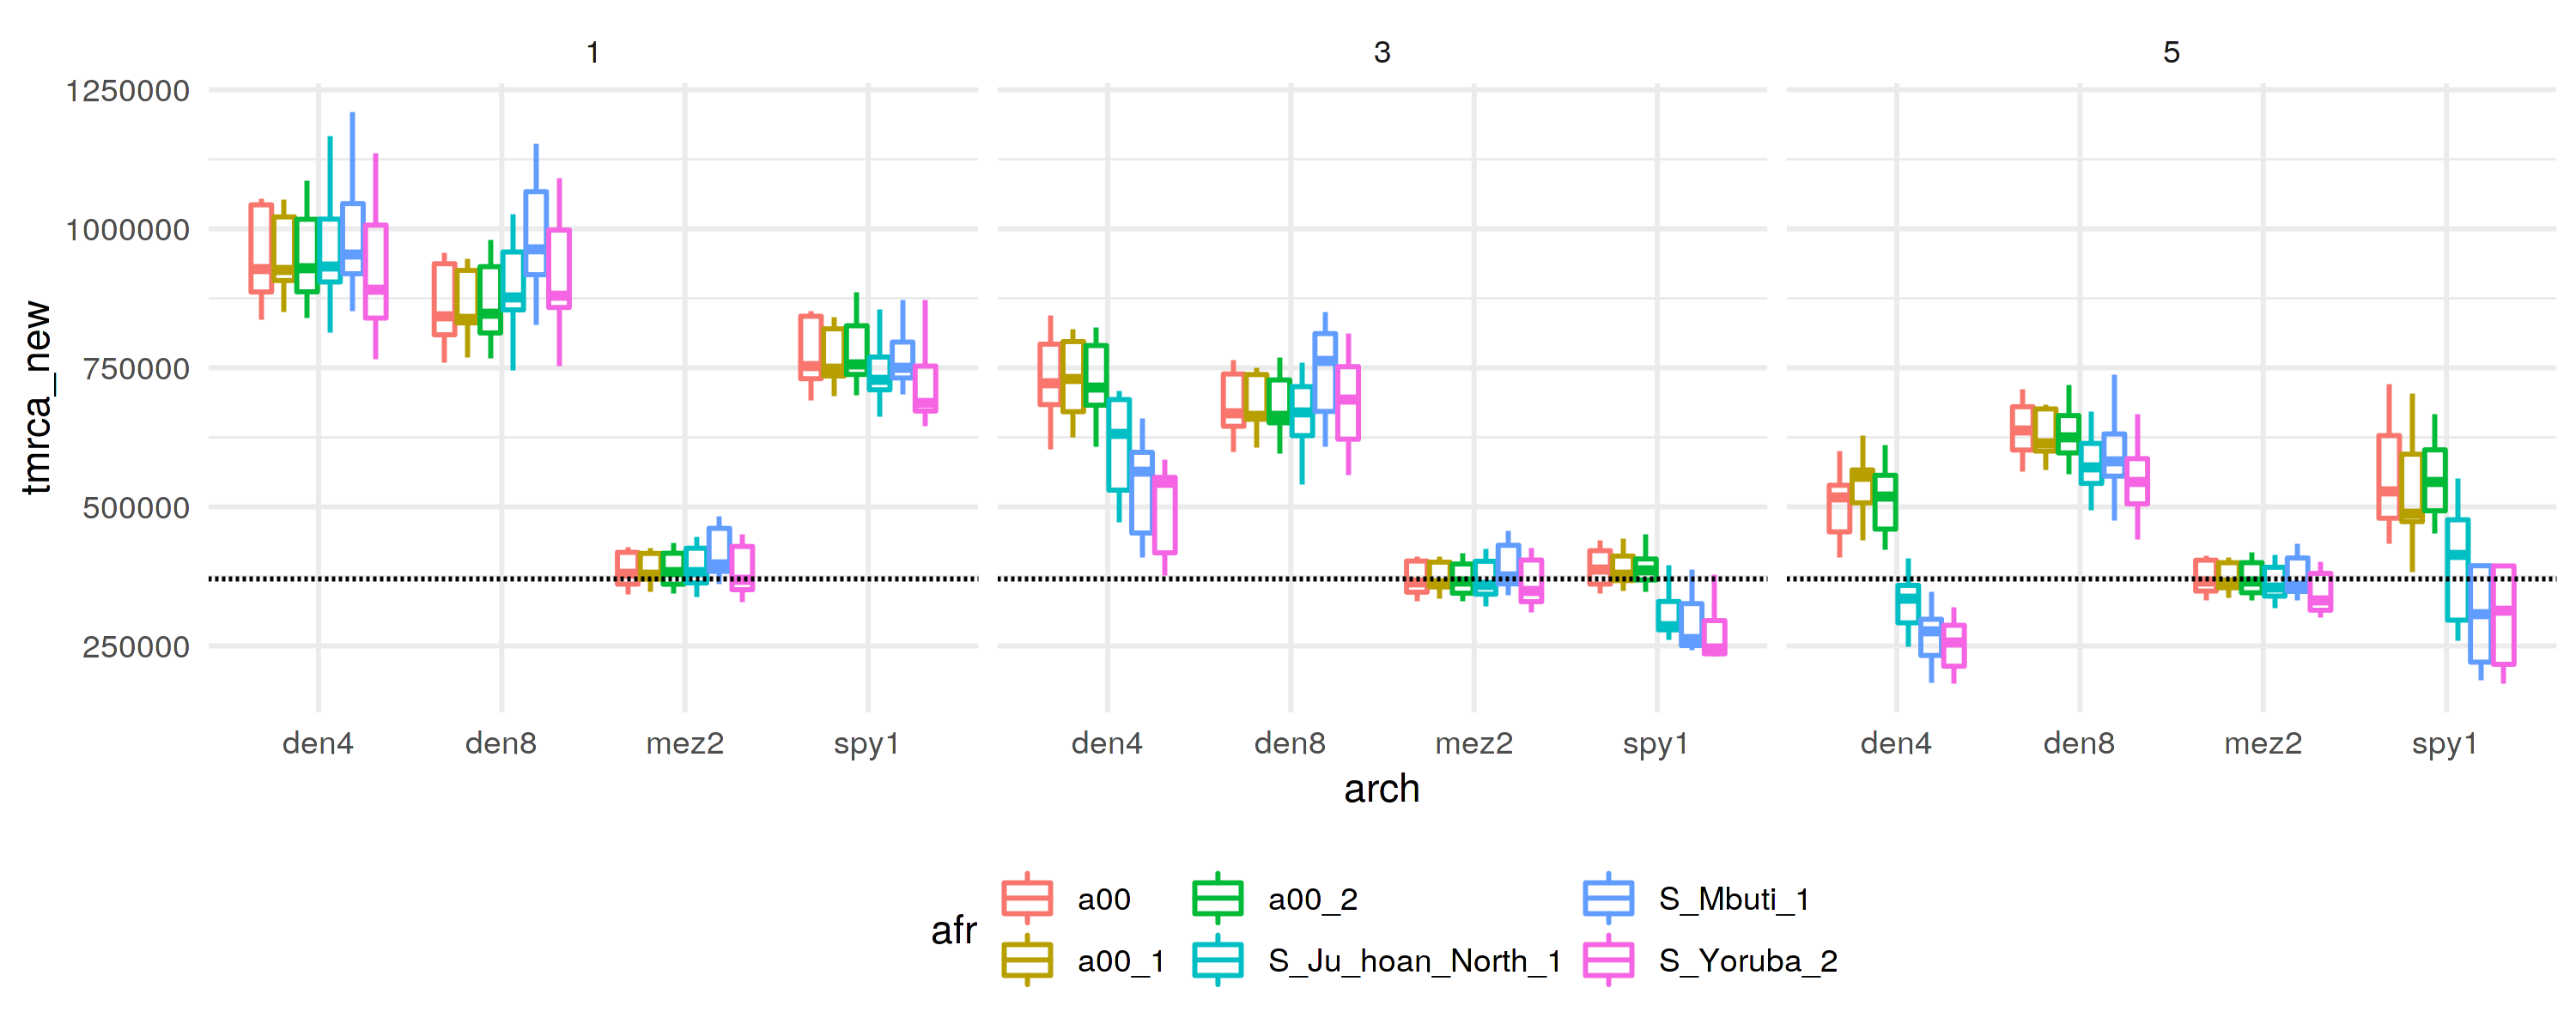

In [25]:
set_dim(10, 4)

tmrca_df %>% filter(!str_detect(arch, "mez2_dp")) %>%
filter(capture == "full", sites == "all", filt == "filt50",
      !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
filter(dp %in% c(1, 3, 5)) %>% {
ggplot(., aes(arch, tmrca_new, color = afr)) +
    geom_boxplot(outlier.shape = NA, alpha = 0.1) +
#    geom_point(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new)) +
#    geom_line(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new, group = afr), linetype = 2) +
    geom_hline(yintercept = 370e3, linetype = 2) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    facet_wrap(dp ~ ., nrow = 1)
}

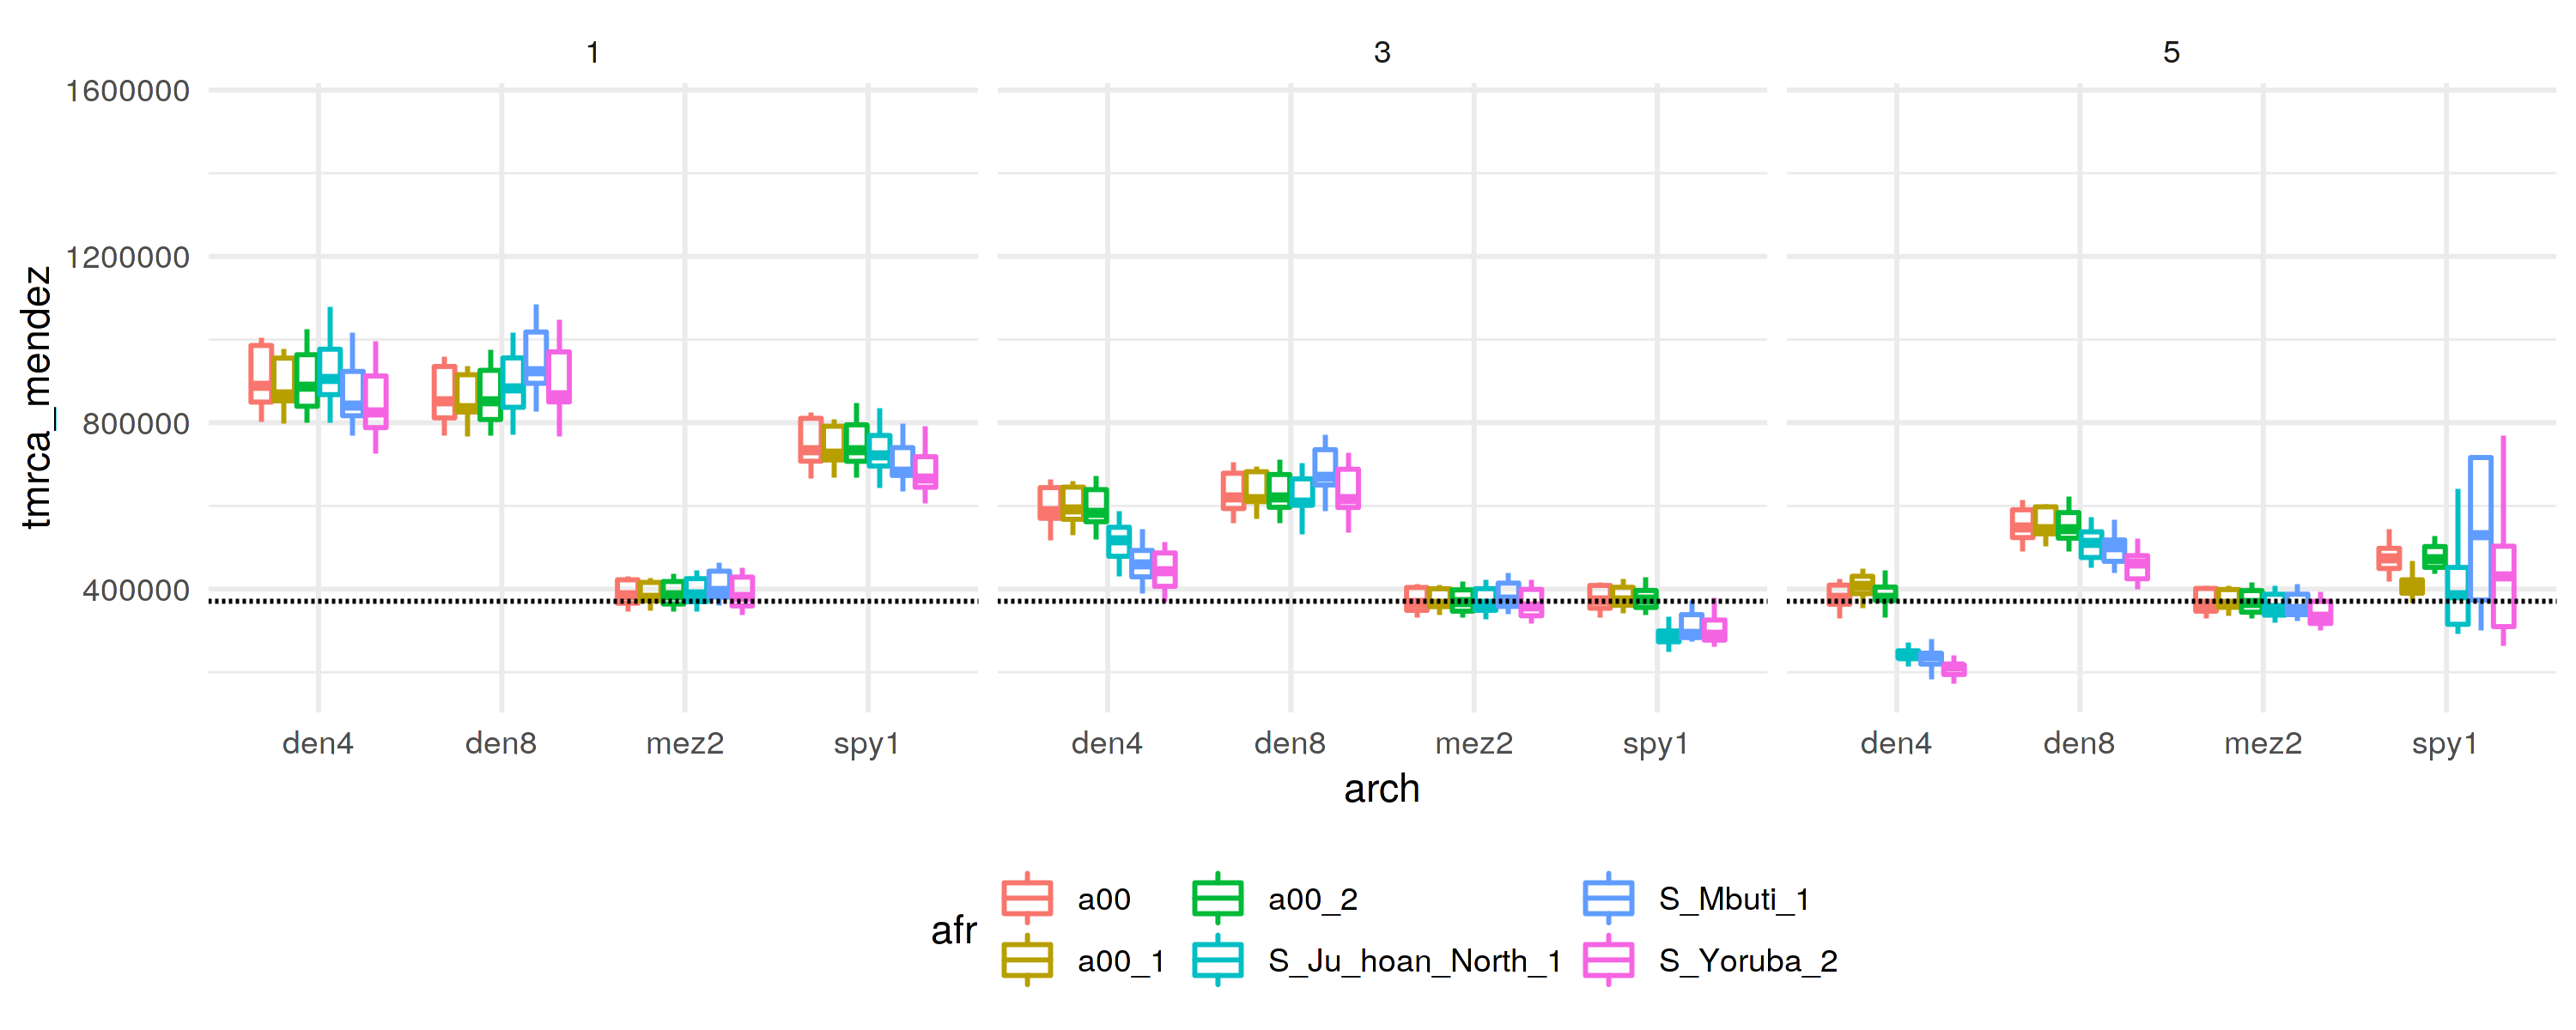

In [26]:
set_dim(10, 4)

tmrca_df %>% filter(!str_detect(arch, "mez2_dp")) %>%
filter(capture == "full", sites == "all", filt == "filt50",
      !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
filter(dp %in% c(1, 3, 5)) %>% {
ggplot(., aes(arch, tmrca_mendez, color = afr)) +
    geom_boxplot(outlier.shape = NA, alpha = 0.1) +
#    geom_point(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new)) +
#    geom_line(data = group_by(., arch, afr) %>% summarise_if(is.numeric, mean), aes(arch, tmrca_new, group = afr), linetype = 2) +
    geom_hline(yintercept = 370e3, linetype = 2) +
    theme_minimal() +
    theme(legend.position = "bottom") +
    facet_wrap(dp ~ ., nrow = 1)
}

In [57]:
branches <- tmrca_df %>%
    filter(sites == "all", filt == "filt50", capture == "full", dp <= 8) %>%
    mutate(n_muts = a + b + c + d + e + f) %>%
    select(arch, afr, ref, dp, a, b, c, d, e, f, total, n_muts, sites) %>%
    gather(branch, count, -c(arch, afr, ref, dp, total, n_muts, sites)) %>% 
    mutate(prop = count / n_muts,
           dp = factor(dp))
head(branches)

arch afr               ref          dp total   n_muts sites branch count
1 den4 S_Ju_hoan_North_1 S_BedouinB_1 1  4400906 25828  all   a      2333 
2 den4 S_Ju_hoan_North_1 S_Turkish_1  1  4405721 25932  all   a      2334 
3 den4 S_Ju_hoan_North_1 S_French_1   1  4412572 25933  all   a      2346 
4 den4 S_Ju_hoan_North_1 S_Burmese_1  1  4379347 25781  all   a      2327 
5 den4 S_Ju_hoan_North_1 S_Thai_1     1  4351537 25611  all   a      2311 
6 den4 S_Ju_hoan_North_1 S_Finnish_2  1  4417538 25967  all   a      2336 
  prop      
1 0.09032833
2 0.09000463
3 0.09046389
4 0.09026027
5 0.09023466
6 0.08996033

Warning message:
“Removed 36 rows containing missing values (geom_point).”

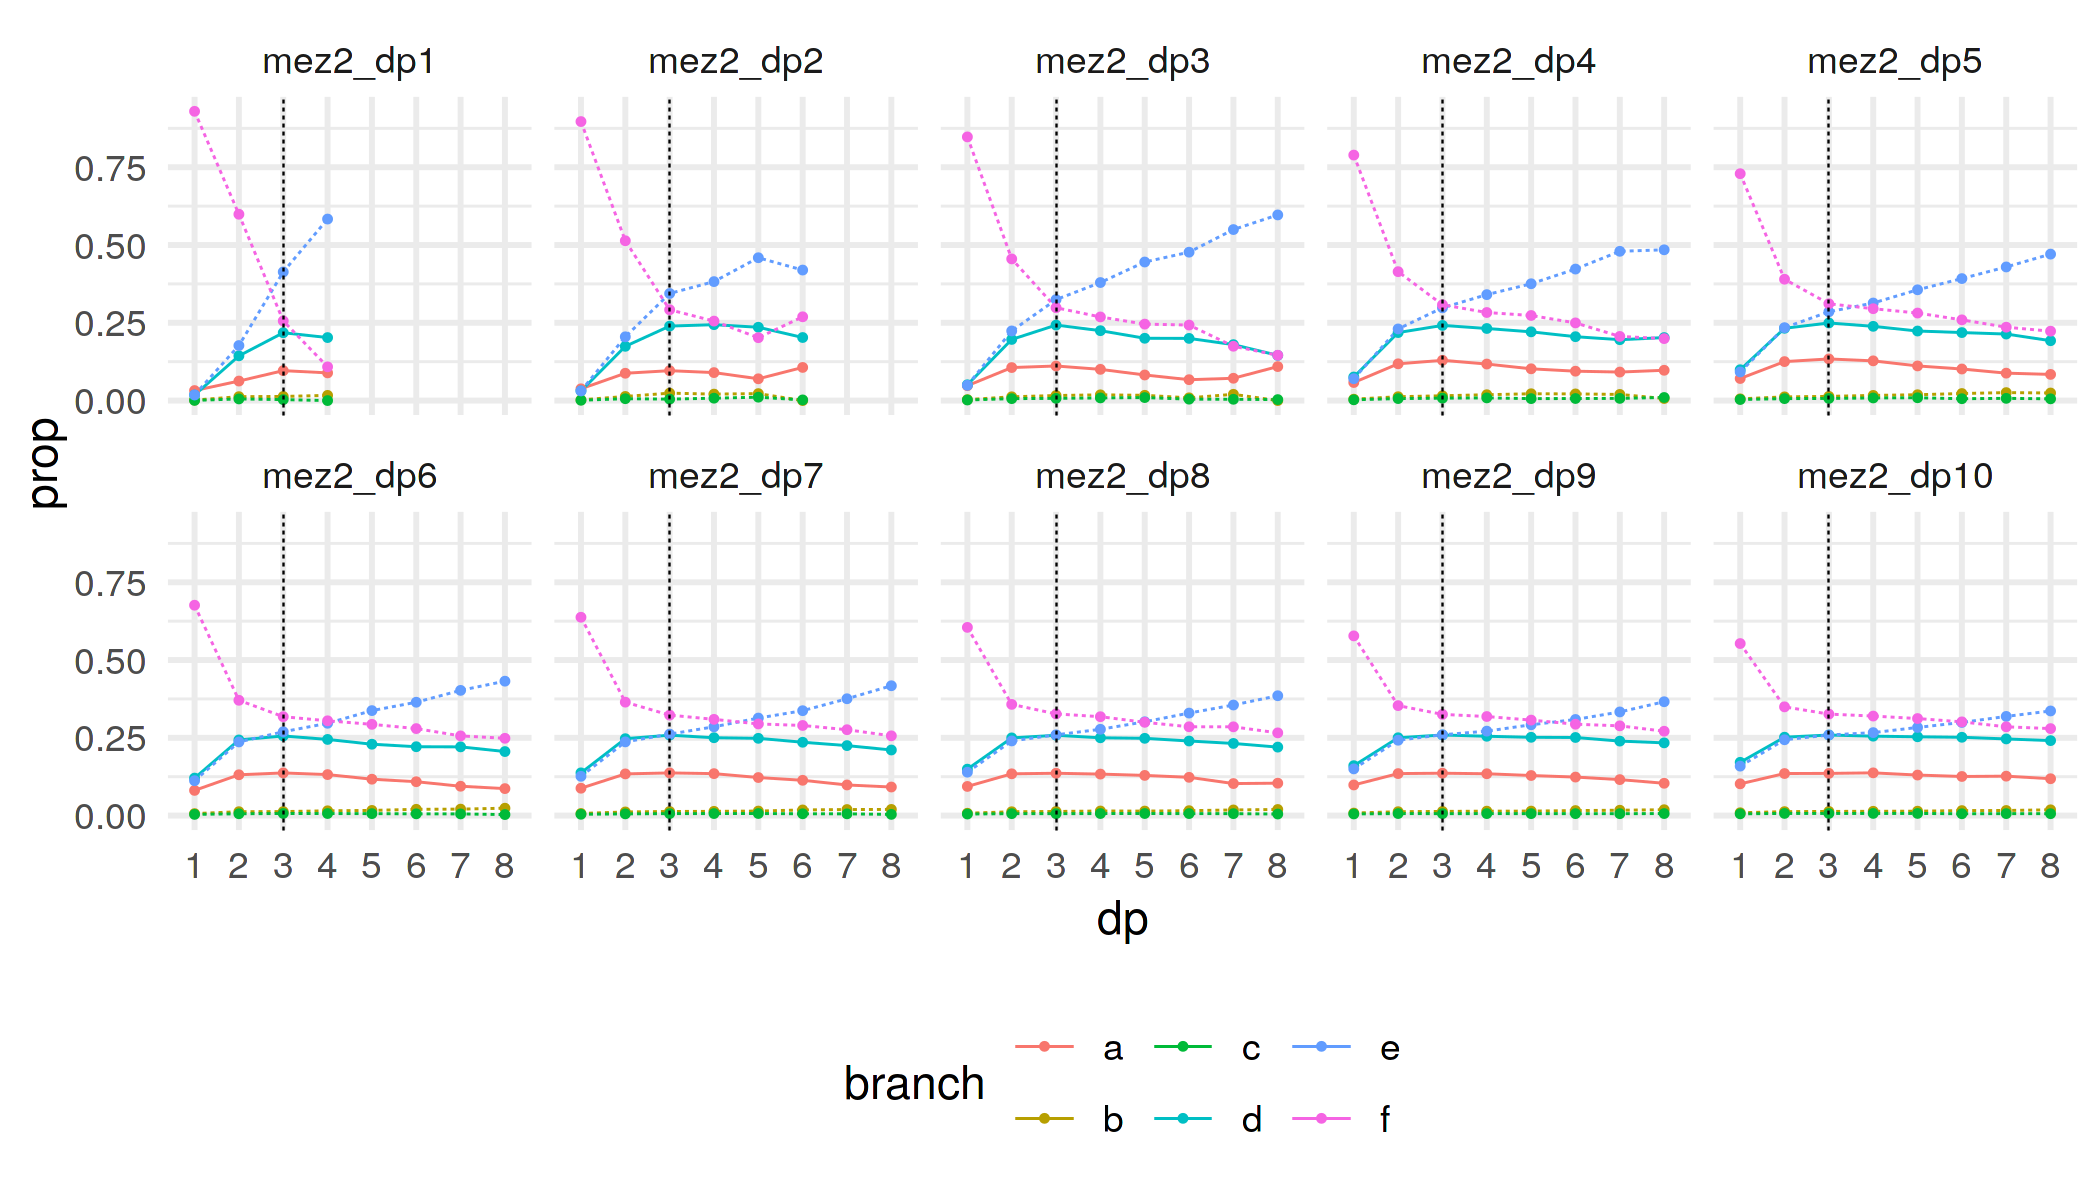

In [58]:
set_dim(7, 4)

branches %>% filter(afr == "a00", str_detect(arch, "mez2_dp")) %>%
ungroup %>%
mutate(arch = factor(arch, levels = paste0("mez2_dp", 1:10))) %>% {
ggplot() +
    # a and d branches
    geom_line(data = filter(., branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1, size = 0.25) +

    # other branches
    geom_line(data = filter(., !branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 0.25) +

    # mean branch count proportions
    geom_point(data = group_by(., arch, afr, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +

    geom_vline(xintercept = 3, linetype = 2, size = 0.2) +

    theme_minimal() +
    theme(legend.position = "bottom") +

    facet_wrap(. ~ arch, nrow = 2)
}

Warning message:
“Removed 468 rows containing missing values (geom_point).”

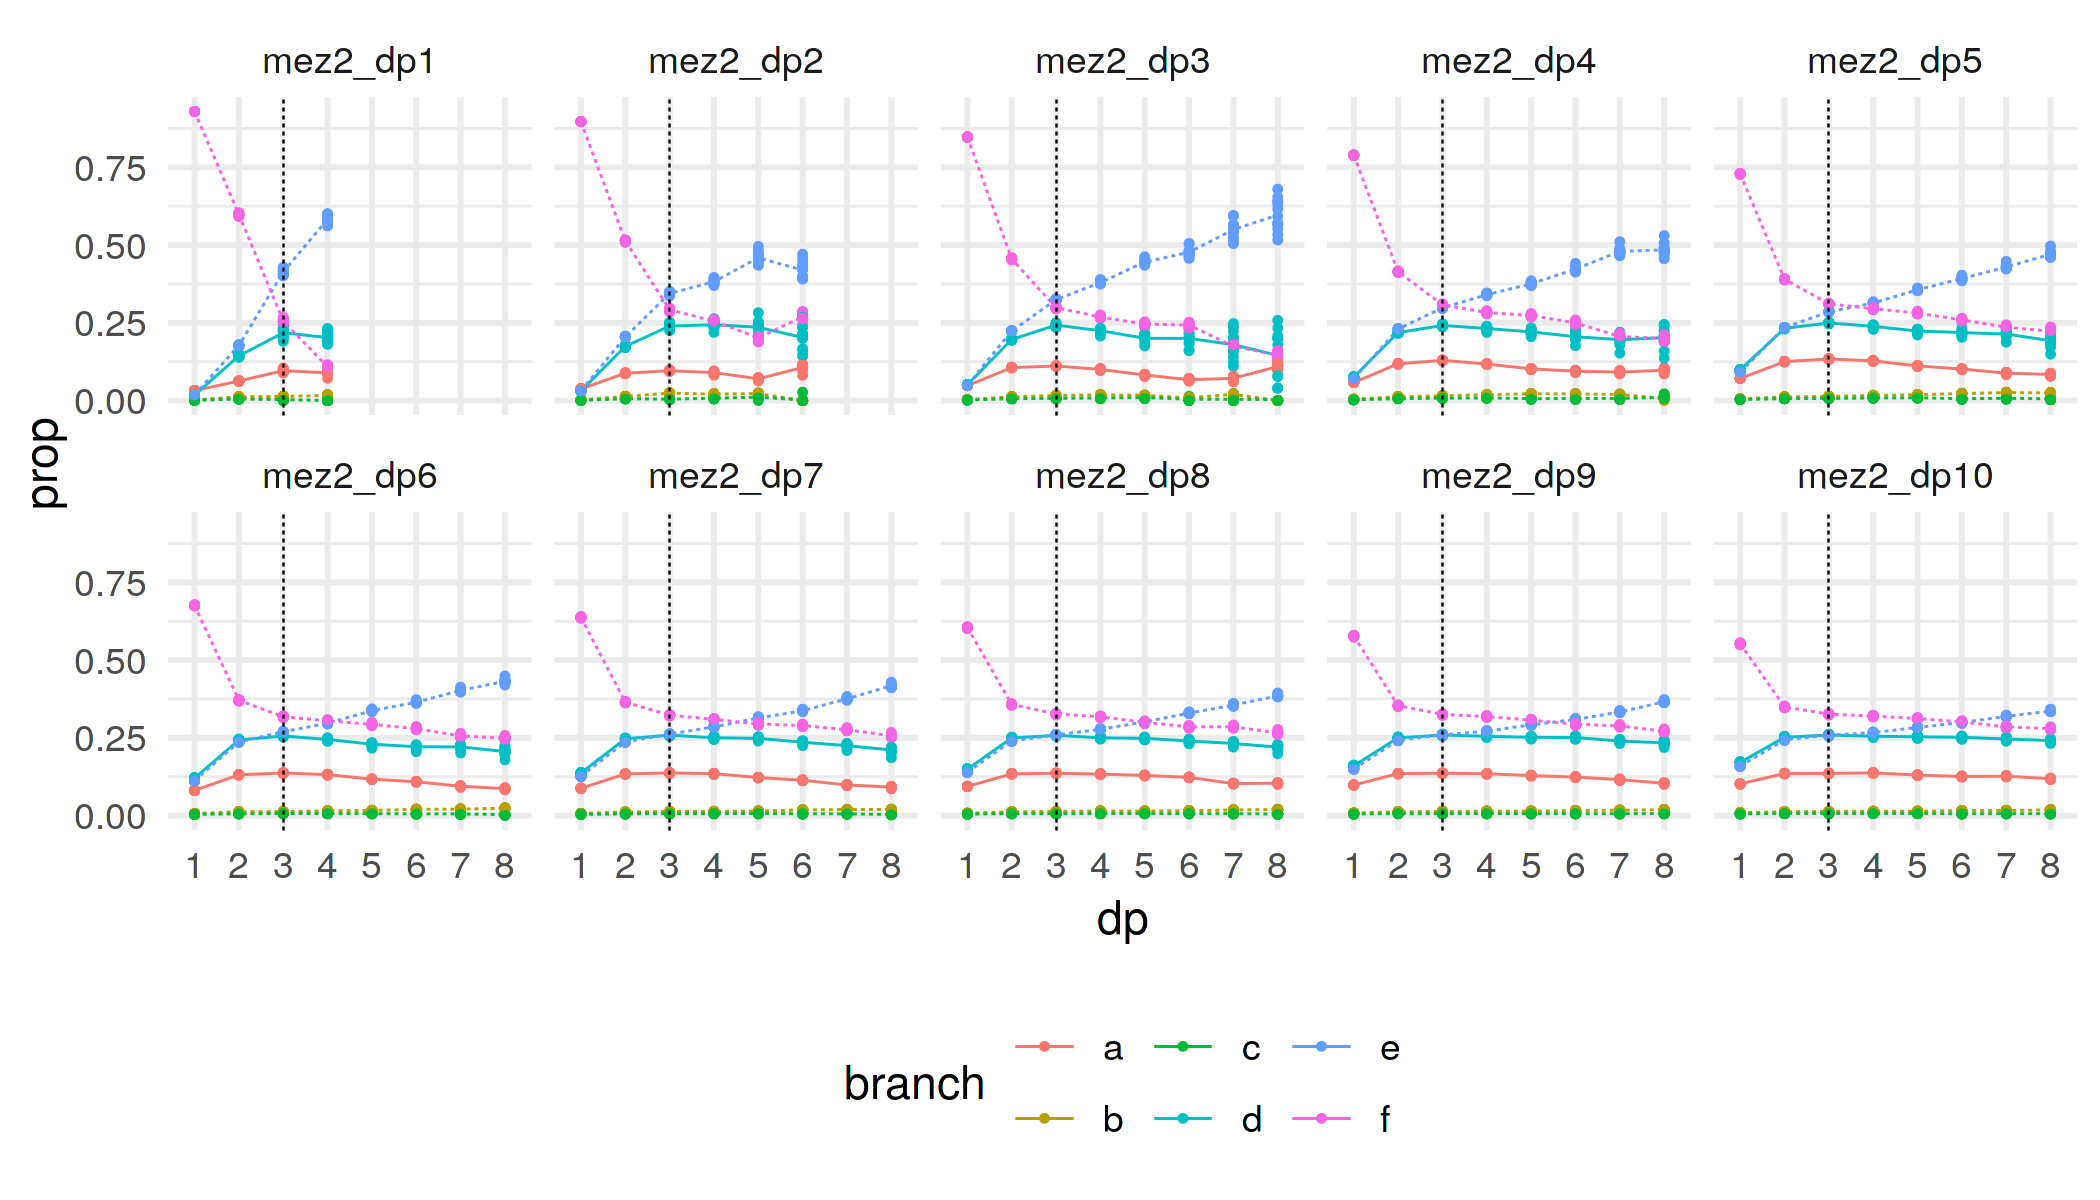

In [59]:
set_dim(7, 4)

branches %>% filter(afr == "a00", str_detect(arch, "mez2_dp")) %>%
ungroup %>%
mutate(arch = factor(arch, levels = paste0("mez2_dp", 1:10))) %>% {
ggplot() +
    # a and d branches
    geom_line(data = filter(., branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1, size = 0.25) +

    # other branches
    geom_line(data = filter(., !branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 0.25) +

    # mean branch count proportions
    geom_point(data = group_by(., arch, afr, ref, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +

    geom_vline(xintercept = 3, linetype = 2, size = 0.2) +

    theme_minimal() +
    theme(legend.position = "bottom") +

    facet_wrap(. ~ arch, nrow = 2)
}

Warning message:
“Removed 1872 rows containing missing values (geom_point).”

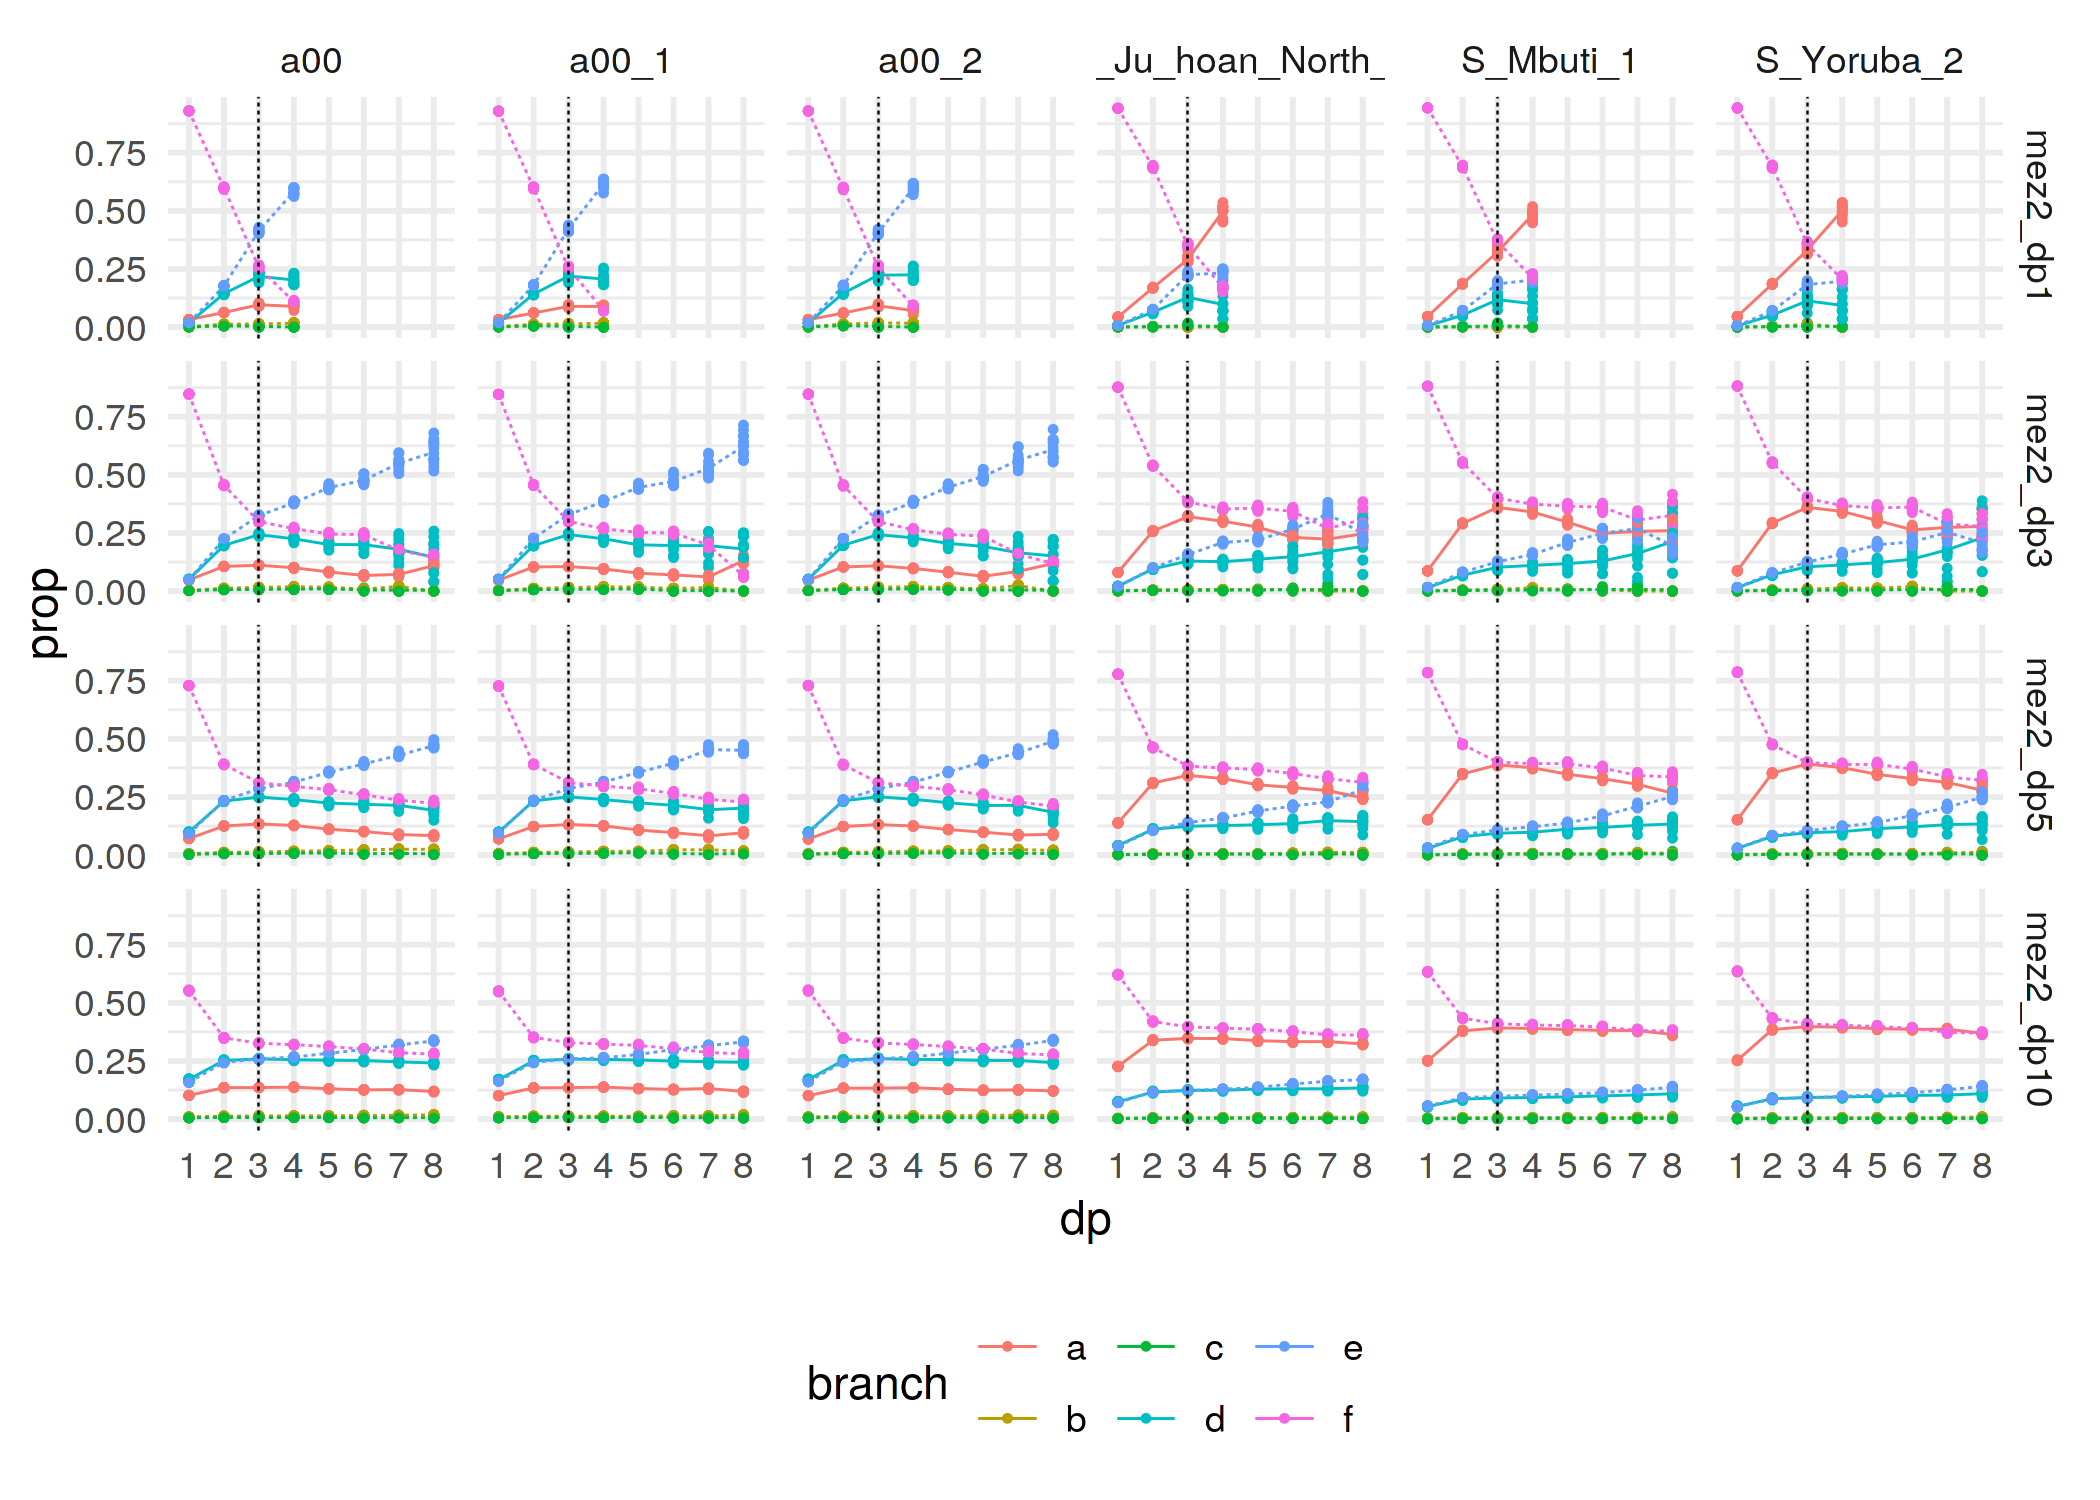

In [64]:
set_dim(7, 5)

branches %>%
ungroup %>% filter(str_detect(arch, "mez2_dp")) %>% 
mutate(arch = factor(arch, levels = paste0("mez2_dp", 1:10))) %>%
filter(
    !str_detect(afr, "(Mandenka|Gambian|Dinka)"),
    arch %in% paste0("mez2_dp", c(1, 3, 5, 10))) %>% {
ggplot() +
    # a and d branches
    geom_line(data = filter(., branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 1, size = 0.25) +

    # other branches
    geom_line(data = filter(., !branch %in% c("a", "d")) %>%
                            group_by(arch, afr, dp, sites, branch) %>%
                            summarise_if(is.numeric, mean),
              aes(dp, prop, color = branch, group = branch), linetype = 2, size = 0.25) +

    # mean branch count proportions
    geom_point(data = group_by(., arch, afr, ref, dp, sites, branch) %>% summarise_if(is.numeric, mean),
               aes(dp, prop, color = branch), size = 1/3) +

    geom_vline(xintercept = 3, linetype = 2, size = 0.2) +

    theme_minimal() +
    theme(legend.position = "bottom") +

    facet_grid(arch ~ afr)
}

Warning message:
“Removed 702 rows containing missing values (geom_point).”

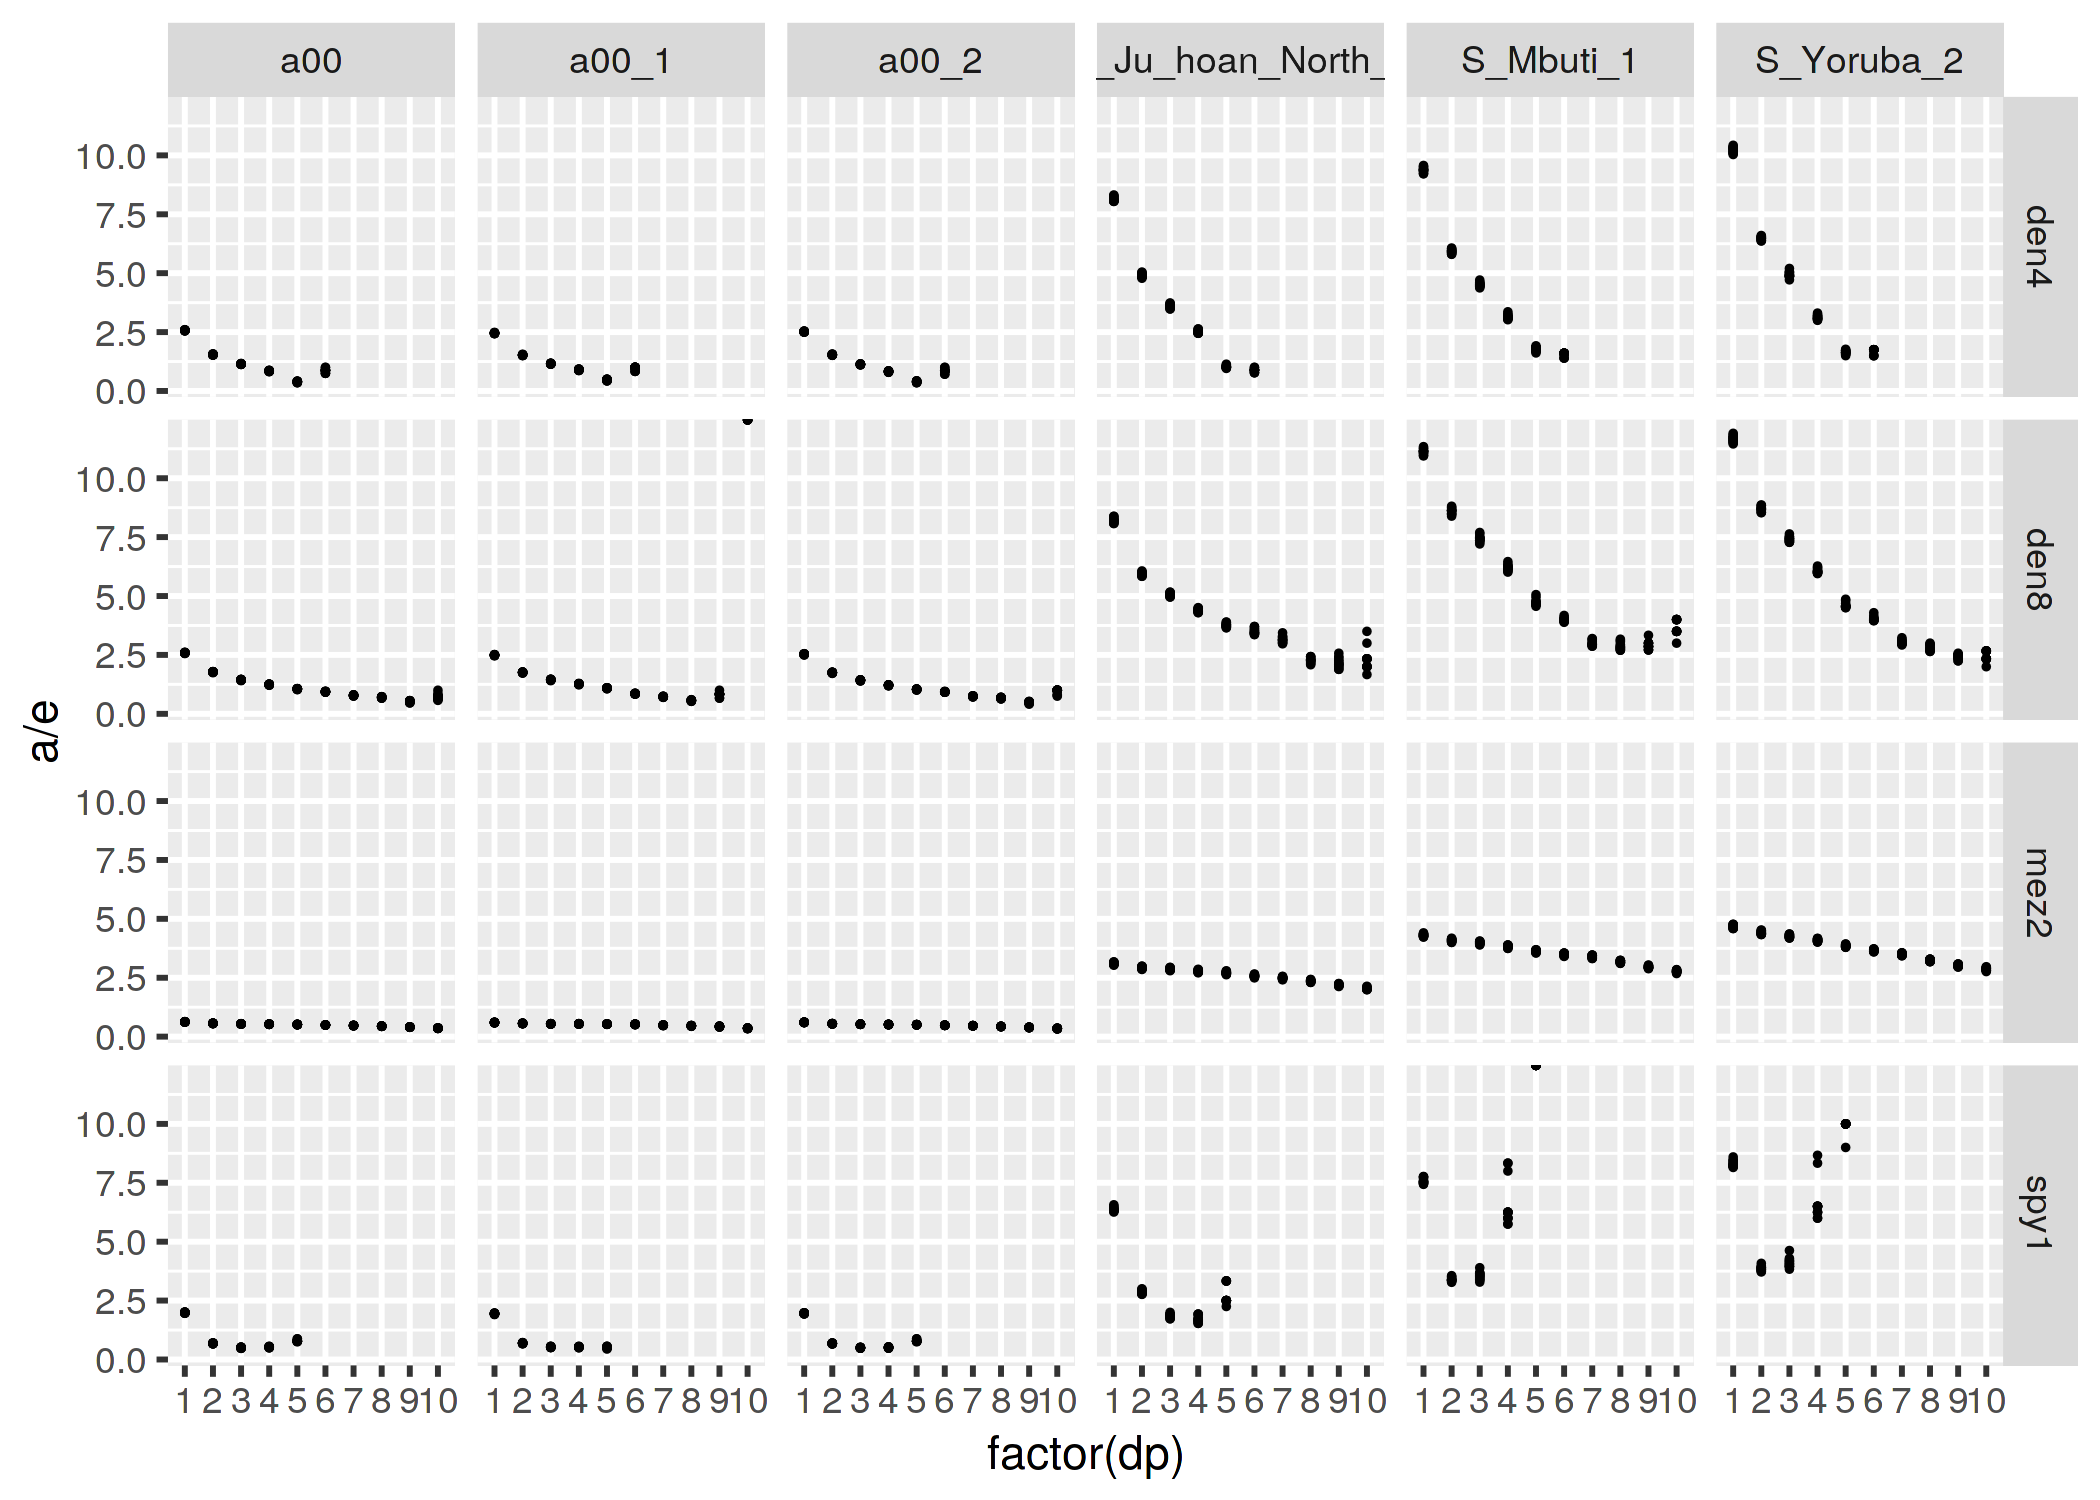

In [66]:
tmrca_df %>%
filter(!str_detect(arch, "mez2_dp")) %>%
filter(capture == "full", sites == "all", filt == "filt50",
      !str_detect(afr, "(Mandenka|Gambian|Dinka)")) %>%
ggplot(aes(factor(dp), a / e)) +
    geom_point(size = 0.2) +
    facet_grid(arch ~ afr)

Warning message:
“Removed 1404 rows containing missing values (geom_point).”

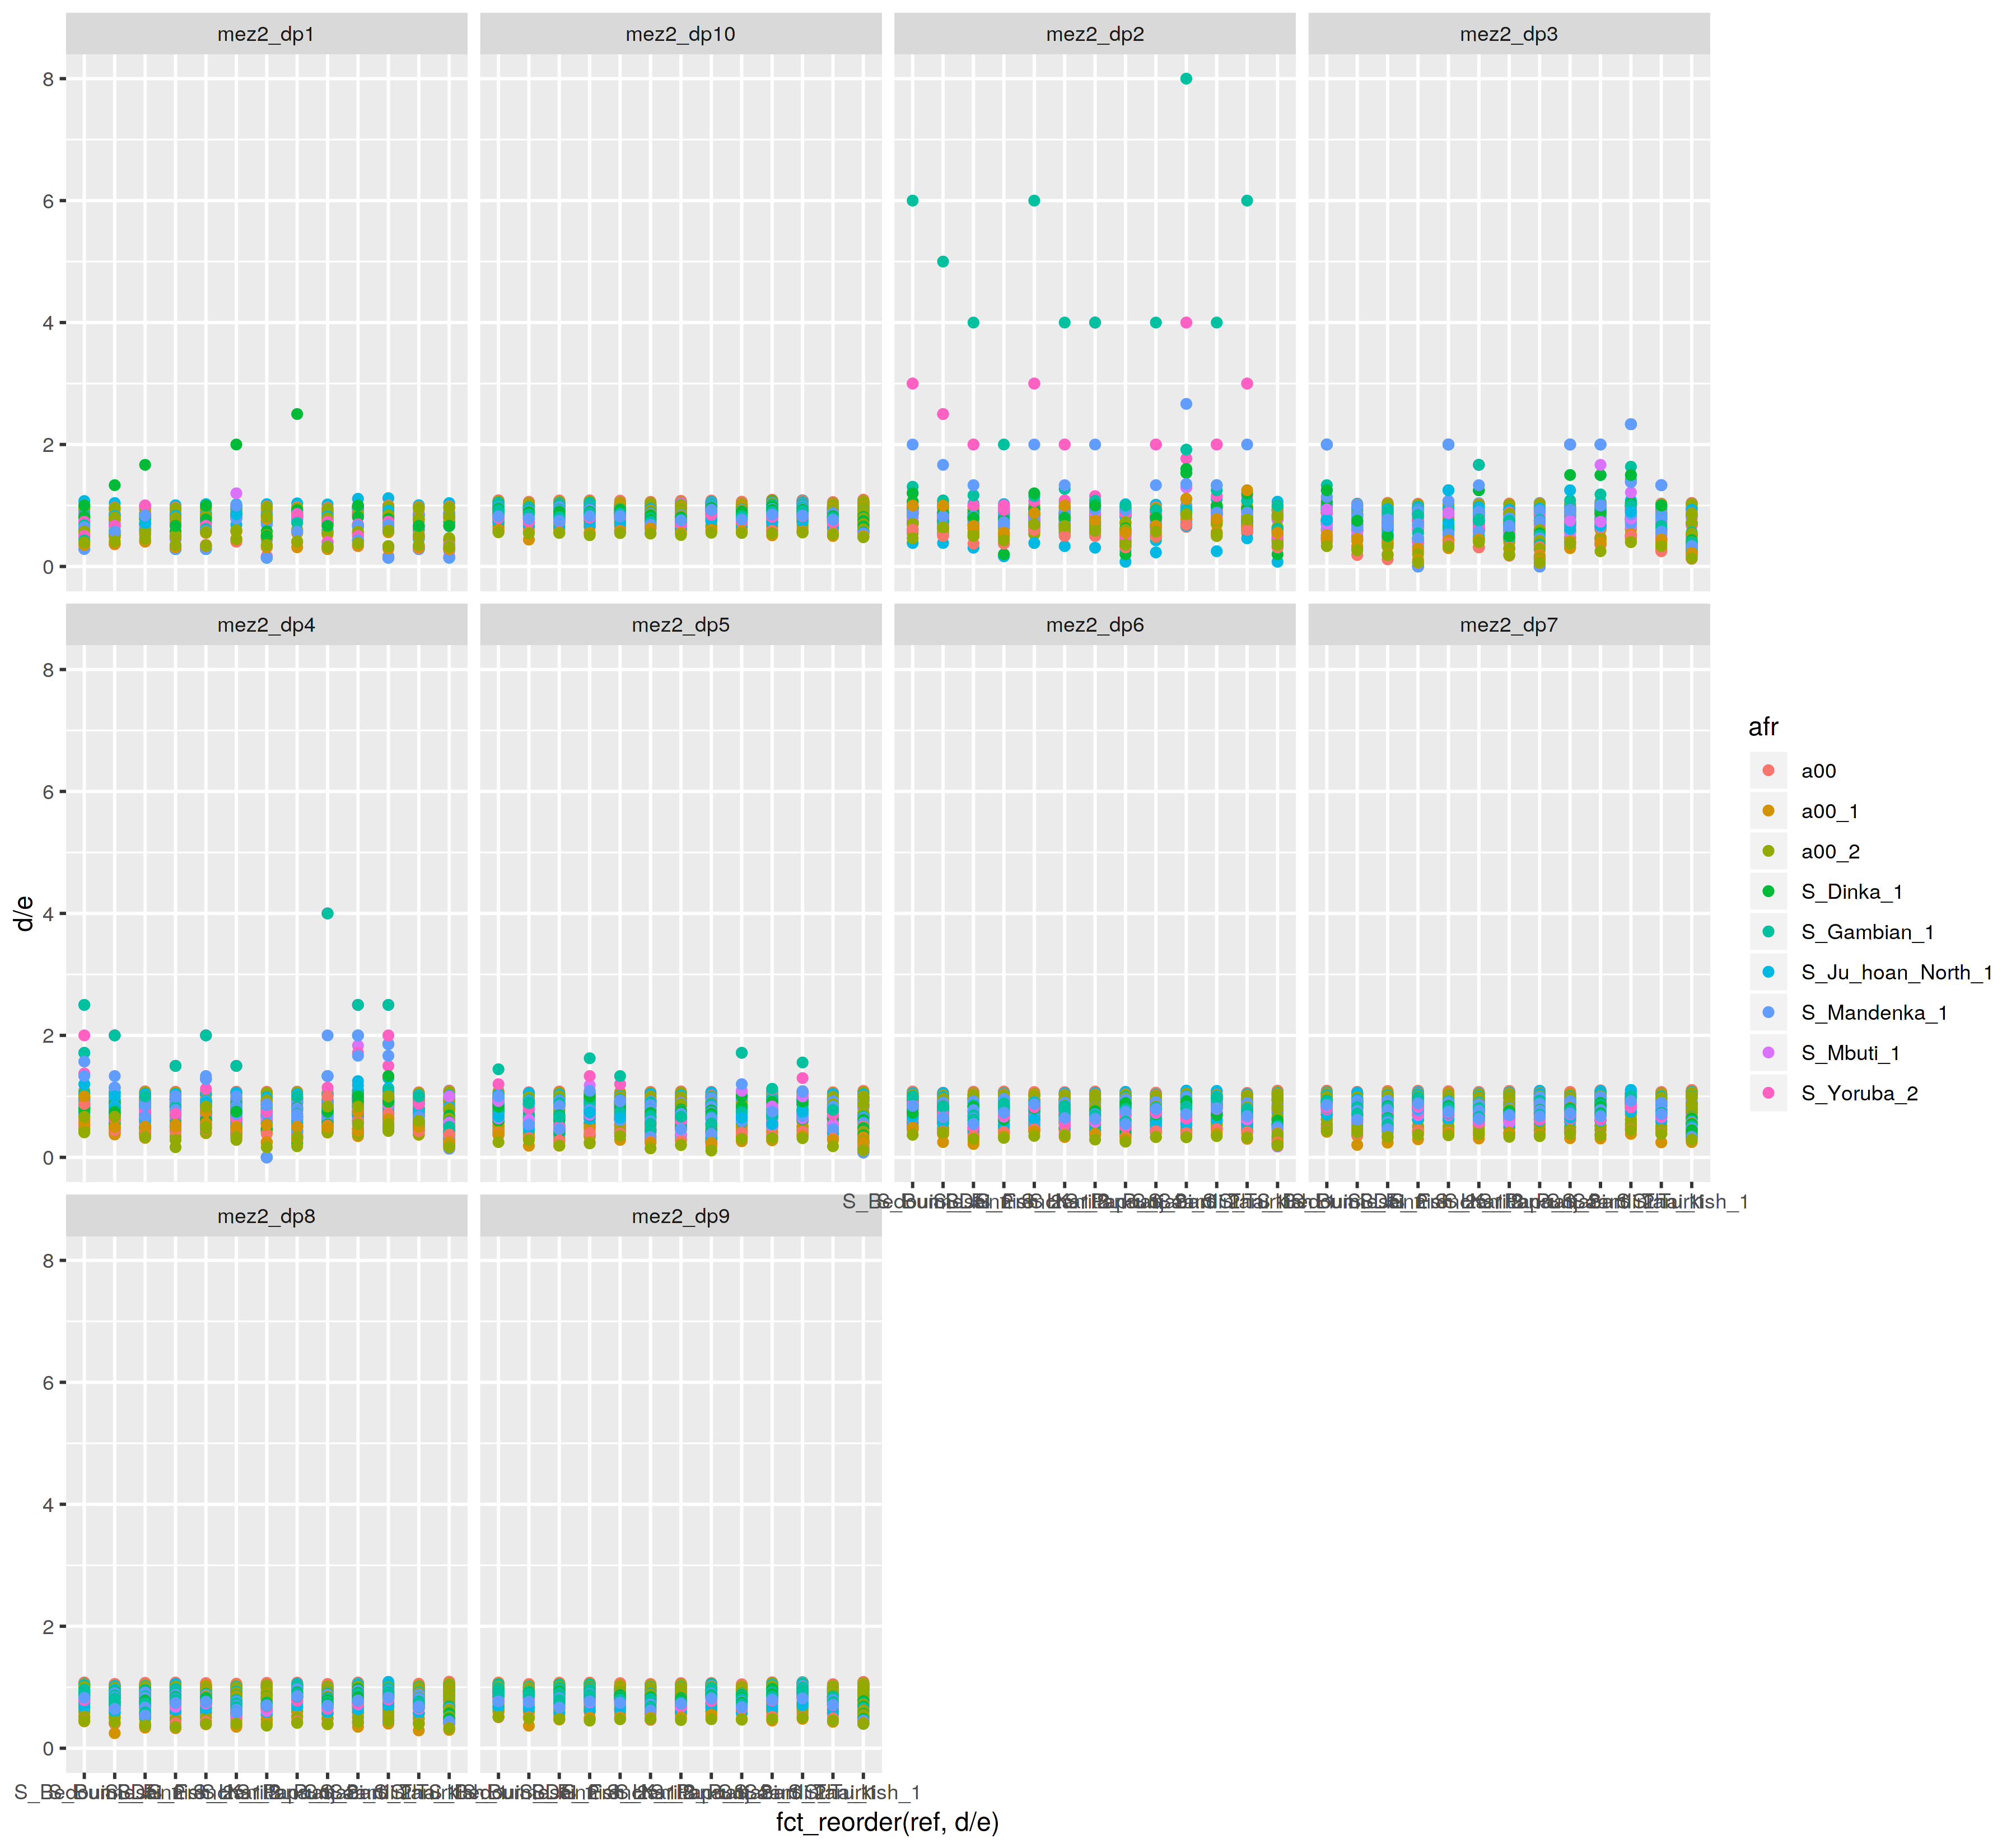

In [108]:
tmrca_df %>%
filter(sites == "all", filt == "filt50", str_detect(arch, "mez2_dp")) %>%
ggplot(aes(fct_reorder(ref, d / e), d / e, color = afr)) +
    geom_point() + facet_wrap(~ arch)